In [5]:
#Main
import pandas as pd
import numpy as np
from math import floor
import time
import pickle
from tqdm import tqdm
from collections import defaultdict

# SKLEARN
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, StratifiedGroupKFold
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import nannyml as nml
colors =  nml.plots.colors.Colors

# METRICS
# Classification 
from sklearn.metrics import balanced_accuracy_score, average_precision_score, roc_auc_score, f1_score, recall_score, precision_score, classification_report
from sklearn.metrics import brier_score_loss
from sklearn.metrics import confusion_matrix

# IMBLEARN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# MODEL ARCHITECTURES
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

# TUNING
from optuna.integration import OptunaSearchCV
from optuna import distributions as optdist
from sklearn.metrics import make_scorer
import optuna

#Explainability
import shap

#Fairness
from fairlearn.metrics import (
    demographic_parity_difference, 
    equalized_odds_difference, 
    false_positive_rate_difference,
    false_negative_rate_difference
)

# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

In [12]:
PAT = '/Users/marinacamacho/Desktop/Master_I/Data_Final'
DIS = "Depression_1"
MOD = "Binary_1"
FET = "45" 

In [13]:
# Read trainCohort_{DIS} file
with open(f"{PAT}/trainCohort_{DIS}", "rb") as fp:
    trainData = pickle.load(fp)
# Read trainLabels_{DIS} file
with open(f"{PAT}/trainLabels_{DIS}", "rb") as fp:
    y_train = pickle.load(fp)

# Read externalCohort_{DIS} file
with open(f"{PAT}/externalCohort_{DIS}", "rb") as fp:
    extCohort = pickle.load(fp)
# Read externalLabels_{DIS} file
with open(f"{PAT}/externalLabels_{DIS}", "rb") as fp:
    y_ext = pickle.load(fp)

# Read traceCohort_{DIS} file
with open(f"{PAT}/traceCohort_{DIS}", "rb") as fp:
    traceCohort = pickle.load(fp)
# Read traceLabels_{DIS} file
with open(f"{PAT}/traceLabels_{DIS}", "rb") as fp:
    y_trace = pickle.load(fp)

In [14]:
eids = trainData.reset_index().iloc[:,0].values
targets = pd.DataFrame(y_train["target"])

In [15]:
X_ext = extCohort.values
X_trace = traceCohort.values
X_train = trainData.values

In [16]:
trainData.shape, extCohort.shape, traceCohort.shape

((73344, 175), (31444, 175), (3967, 175))

In [17]:
y_train.shape, y_ext.shape, y_trace.shape

((73344, 1), (31444, 1), (3967, 1))

In [18]:
y_train['target'].value_counts()

0    58407
1    14937
Name: target, dtype: int64

In [19]:
y_train['target'].value_counts()

0    58407
1    14937
Name: target, dtype: int64

In [20]:
y_ext['target'].value_counts()

0    24594
1     6850
Name: target, dtype: int64

In [21]:
y_trace['target'].value_counts()

0    3239
1     728
Name: target, dtype: int64

In [22]:
# Define data processing pipeline

In [23]:
Normalize = False # Flag to determine whether to normalize data or not
OuterFolds = 5 # Number of outer cross-validation folds for model evaluation
InnerFolds = 3 # Number of inner cross-validation folds for hyperparameter tuning
random_state = 28 # Seed for random number generation to ensure reproducibility

In [24]:
# XGBoost Pipeline
XGB = XGBClassifier(random_state=random_state)

XGB_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan,
                            strategy='median')),
    ('RUS', RandomUnderSampler(random_state=random_state)),
    #('SMOTE', SMOTE(random_state=random_state)),
    ('select_features', SelectFromModel(RandomForestClassifier(), threshold='median', max_features=45)),
    ('XGB', XGB)
    ])

# Logistic Regression Pipeline
LReg = LogisticRegression(random_state=random_state)

LReg_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan,
                            strategy='median')),
    ('RUS', RandomUnderSampler(random_state=random_state)),
    #('SMOTE', SMOTE(random_state=random_state)),
    ('select_features', SelectFromModel(RandomForestClassifier(), threshold='median', max_features=45)),
    ('LReg', LReg)
])

# Support Vector Machine Pipeline
SVM = SVC(probability=True, random_state=random_state)

SVM_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan,
                            strategy='median')),
    ('RUS', RandomUnderSampler(random_state=random_state)),
    #('SMOTE', SMOTE(random_state=random_state)),
    ('select_features', SelectFromModel(RandomForestClassifier(), threshold='median', max_features=45)),
    ('SVM', SVM)
])

In [25]:
# Parameter search space for XGBoost model
XGB_params = {
    'XGB__learning_rate': optdist.FloatDistribution(low=0.05, high=0.3),
    'XGB__min_child_weight': optdist.IntDistribution(low=1, high=5),
    'XGB__gamma': optdist.FloatDistribution(low=0.5, high=2),
    'XGB__subsample': optdist.FloatDistribution(low=0.6, high=1),
    'XGB__colsample_bytree': optdist.FloatDistribution(low=0.6, high=1),
    'XGB__max_depth': optdist.IntDistribution(low=2, high=12)}

# Parameter search space for Logistic Regression model
LReg_params = {
    'LReg__penalty': optdist.CategoricalDistribution(['l2']),
    'LReg__solver': optdist.CategoricalDistribution(['newton-cg', 'lbfgs', 'liblinear']),
    'LReg__max_iter': optdist.IntDistribution(low=100, high=300),
    'LReg__C': optdist.FloatDistribution(low=0, high=100)}

# Parameter search space for Support Vector Machine model
SVM_params = {
    'SVM__C': optdist.FloatDistribution(low=0, high=100),
    'SVM__kernel': optdist.CategoricalDistribution(['linear', 'rbf']),
    'SVM__gamma':  optdist.FloatDistribution(low=0.001, high=1),
    'SVM__max_iter': optdist.IntDistribution(low=100, high=300)}

In [26]:
hyperparameters = {'SVM': SVM_params,
                   'LReg': LReg_params,
                   'XGB': XGB_params}

pipelines = {'SVM': SVM_pipeline,
             'LReg': LReg_pipeline,
             'XGB': XGB_pipeline}

In [27]:
def thresholdSelector(model, val, val_labels, score_func):
    probs = model.predict_proba(val)[:,1]
    prec, recall, thresholds = precision_recall_curve(val_labels, probs)
    fscore = (2 * prec * recall) / (prec + recall)
    best_thresh = thresholds[argmax(nan_to_num(fscore,nan=0.0))]
    return best_thresh

def thresholdPredictor(model, X, ground, threshold, score_func):
    probs = model.predict_proba(X)
    probs = array([guess[1] for guess in probs])
    pred = where(probs > threshold, 1, 0)

    score = score_func(y_true=ground, y_pred=pred)
    return score

In [22]:
inner_scoring = make_scorer(roc_auc_score, needs_proba=True)
skf = StratifiedKFold(n_splits=OuterFolds)

for i, (train_index, val_index) in enumerate(skf.split(trainData, targets)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={val_index}")
    
    fitted_models=dict()
    
    for name, pipeline in pipelines.items():
        print(f"Fitting {name}...")
        foldModels = {i: {
            'model': None,
            'threshold': 0.5
        } for i in range(OuterFolds)}
       
        Outer_start = time.perf_counter()

        for i in tqdm(range(OuterFolds)):
            # Pull training and validation splits for the outer fold 
            train_eids = list(pd.DataFrame(trainData.index).iloc[train_index]['eid'])
            val_eids = list(pd.DataFrame(trainData.index).iloc[val_index]['eid'])

            X_train = trainData.query('eid == @train_eids')
            X_val = trainData.query('eid == @val_eids')

            y_train = targets.query('eid == @train_eids')
            y_val = targets.query('eid == @val_eids')

            Inner_start = time.perf_counter()
            # Perform inner cross validation for hyper parameter tuning
            Inner_CV = OptunaSearchCV(
                estimator=pipeline,
                param_distributions=hyperparameters[name],
                cv=InnerFolds,
                error_score="raise",
                n_trials=10,
                scoring=inner_scoring,
                verbose=False,
                refit=True
            )

            Inner_CV.fit(X_train, y_train)

            best_model = Inner_CV.best_estimator_
            foldModels[i]['model'] = best_model

            # Evaluate optimal threshold on validation set
            pred_thresh = thresholdSelector(best_model, X_val.values, y_val.values, f1_score)
            foldModels[i]['threshold'] = pred_thresh
            foldModels[i]['features'] = foldModels[i]['model']['select_features'].get_support(indices=True)

            Inner_end = time.perf_counter()

        Outer_end = time.perf_counter()
        fitted_models[name] = foldModels
            
    with open(f"{PAT}/{MOD}/fitted_models_{DIS}{FET}", "wb") as fp:
                pickle.dump(fitted_models, fp)

Fold 0:
  Train: index=[14570 14571 14572 ... 73341 73342 73343]
  Test:  index=[    0     1     2 ... 15024 15027 15029]
Fitting SVM...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 11:52:28,008] A new study created in memory with name: no-name-e781d42d-481d-405b-b69c-4bfb38b6e8e3
[I 2023-08-17 11:52:40,095] Trial 0 finished with value: 0.548925927283725 and parameters: {'SVM__C': 30.056185810364987, 'SVM__kernel': 'linear', 'SVM__gamma': 0.23808476787189126, 'SVM__max_iter': 107}. Best is trial 0 with value: 0.548925927283725.
[I 2023-08-17 11:52:52,603] Trial 1 finished with value: 0.5447401832137114 and parameters: {'SVM__C': 82.15016215640013, 'SVM__kernel': 'linear', 'SVM__gamma': 0.6086859807685149, 'SVM__max_iter': 289}. Best is trial 0 with value: 0.548925927283725.
[I 2023-08-17 11:53:10,872] Trial 2 finished with value: 0.5 and parameters: {'SVM__C': 7.941386640690906, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.9745982267244071,

invalid value encountered in true_divide
 60%|████████████████████████████████████████████████████▊                                   | 3/5 [08:22<05:37, 168.87s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 12:00:50,279] A new study created in memory with name: no-name-1edfe31f-8d23-4879-824a-34575e8f16cc
[I 2023-08-17 12:01:01,817] Trial 0 finished with value: 0.5193644545351942 and parameters: {'SVM__C': 51.42721872493994, 'SVM__kernel': 'linear', 'SVM__gamma': 0.7473752153249329, 'SVM__max_iter': 158}. Best is trial 0 with value: 0.5193644545351942.
[I 2023-08-17 12:01:13,155] Trial 1 finished with value: 0.5189681014255858 and parameters: {'SVM__C': 90.42190680411164, 'SVM__kernel': 'linear', 'SVM__gamma': 0.10472232878362828, 'SVM__max_iter': 129}. Best is trial 0 with value: 0.5193644545351942.
[I 2023-08-17 12:01:25,429] Trial 2 finished with value: 0.5559335570964956 and parameters: {'SVM__C': 71.9803150273865

Fitting LReg...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 12:06:03,673] A new study created in memory with name: no-name-9479bb82-cde4-4e5e-a933-cbc6617c799a
[I 2023-08-17 12:06:16,991] Trial 0 finished with value: 0.8461614994494725 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 190, 'LReg__C': 10.093956453182729}. Best is trial 0 with value: 0.8461614994494725.
[I 2023-08-17 12:06:35,738] Trial 1 finished with value: 0.8461365716156202 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'newton-cg', 'LReg__max_iter': 133, 'LReg__C': 92.53720298650164}. Best is trial 0 with value: 0.8461614994494725.
[I 2023-08-17 12:06:49,572] Trial 2 finished with value: 0.8128752683159878 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'lbfgs', 'LReg__max_iter': 217, 'LReg_

 60%|████████████████████████████████████████████████████▊                                   | 3/5 [08:14<05:26, 163.03s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 12:14:18,726] A new study created in memory with name: no-name-40185b56-dafc-45ea-8956-eeca1f5a0f99
[I 2023-08-17 12:14:33,574] Trial 0 finished with value: 0.8464900911764071 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'newton-cg', 'LReg__max_iter': 246, 'LReg__C': 26.899316306271047}. Best is trial 0 with value: 0.8464900911764071.
[I 2023-08-17 12:14:49,306] Trial 1 finished with value: 0.8203675716399981 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'lbfgs', 'LReg__max_iter': 244, 'LReg__C': 34.38887040213277}. Best is trial 0 with value: 0.8464900911764071.
[I 2023-08-17 12:15:07,937] Trial 2 finished with value: 0.8458371657173466 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'newton-cg', 'LReg__max_iter': 225, 'LReg_

Fitting XGB...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 12:19:35,447] A new study created in memory with name: no-name-a99cfd92-c425-4ab9-83e4-e7f306b3f4d1
[I 2023-08-17 12:20:04,350] Trial 0 finished with value: 0.8345379624189936 and parameters: {'XGB__learning_rate': 0.2940043705197557, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.451806079077781, 'XGB__subsample': 0.8454099078687779, 'XGB__colsample_bytree': 0.8032453413903783, 'XGB__max_depth': 7}. Best is trial 0 with value: 0.8345379624189936.
[I 2023-08-17 12:20:39,656] Trial 1 finished with value: 0.8341758350795843 and parameters: {'XGB__learning_rate': 0.2798340127806466, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.4601476291995015, 'XGB__subsample': 0.7719011716260189, 'XGB__colsample_bytree': 0.8842996955044664, 'XGB__max_depth': 7}. Best is trial 

[I 2023-08-17 12:28:25,458] Trial 1 finished with value: 0.8547486161553625 and parameters: {'XGB__learning_rate': 0.10463816025959373, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.6133489825732621, 'XGB__subsample': 0.8254335925613576, 'XGB__colsample_bytree': 0.8117805730807028, 'XGB__max_depth': 5}. Best is trial 0 with value: 0.8552000159137357.
[I 2023-08-17 12:28:39,323] Trial 2 finished with value: 0.8557655710065571 and parameters: {'XGB__learning_rate': 0.09819888879367829, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.7656086959608182, 'XGB__subsample': 0.6280398826087118, 'XGB__colsample_bytree': 0.8805407586374638, 'XGB__max_depth': 4}. Best is trial 2 with value: 0.8557655710065571.
[I 2023-08-17 12:28:56,528] Trial 3 finished with value: 0.8511817018647753 and parameters: {'XGB__learning_rate': 0.0927721813269682, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.0965954600498957, 'XGB__subsample': 0.7171328290017326, 'XGB__colsample_bytree': 0.732770219667803, 'XGB__max_depth': 8

[I 2023-08-17 12:34:28,490] Trial 3 finished with value: 0.8389881392359637 and parameters: {'XGB__learning_rate': 0.19371101864918122, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.7617786353025744, 'XGB__subsample': 0.7520790895222649, 'XGB__colsample_bytree': 0.8054800971926201, 'XGB__max_depth': 10}. Best is trial 1 with value: 0.8552358366410594.
[I 2023-08-17 12:34:40,362] Trial 4 finished with value: 0.8537440466643579 and parameters: {'XGB__learning_rate': 0.17547422625339953, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.6846076894976219, 'XGB__subsample': 0.883090437313202, 'XGB__colsample_bytree': 0.6419332301301344, 'XGB__max_depth': 2}. Best is trial 1 with value: 0.8552358366410594.
[I 2023-08-17 12:34:52,985] Trial 5 finished with value: 0.8509681669659824 and parameters: {'XGB__learning_rate': 0.26631987330964385, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.9671441932005014, 'XGB__subsample': 0.8202757634477482, 'XGB__colsample_bytree': 0.879951624150622, 'XGB__max_depth': 

Fold 1:
  Train: index=[    0     1     2 ... 73341 73342 73343]
  Test:  index=[14570 14571 14572 ... 29361 29366 29369]
Fitting SVM...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 12:36:04,647] A new study created in memory with name: no-name-d1e65e49-dd93-4fd6-85a2-11ae667140ed
[I 2023-08-17 12:36:17,976] Trial 0 finished with value: 0.5624036312064774 and parameters: {'SVM__C': 74.96287746948296, 'SVM__kernel': 'linear', 'SVM__gamma': 0.6753493752612277, 'SVM__max_iter': 272}. Best is trial 0 with value: 0.5624036312064774.
[I 2023-08-17 12:36:34,009] Trial 1 finished with value: 0.49968252983150574 and parameters: {'SVM__C': 2.7180619040621856, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.12477661208084505, 'SVM__max_iter': 108}. Best is trial 0 with value: 0.5624036312064774.
[I 2023-08-17 12:36:54,277] Trial 2 finished with value: 0.5 and parameters: {'SVM__C': 97.12321343925451, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.4099890329773572

invalid value encountered in true_divide
 60%|████████████████████████████████████████████████████▊                                   | 3/5 [09:44<06:37, 198.61s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 12:45:48,499] A new study created in memory with name: no-name-86f5a240-bed4-4de3-8c0d-9535ede17458
[I 2023-08-17 12:46:00,395] Trial 0 finished with value: 0.5272250667979815 and parameters: {'SVM__C': 90.4281737498231, 'SVM__kernel': 'linear', 'SVM__gamma': 0.2846728906847607, 'SVM__max_iter': 195}. Best is trial 0 with value: 0.5272250667979815.
[I 2023-08-17 12:46:12,190] Trial 1 finished with value: 0.5074772405359931 and parameters: {'SVM__C': 36.748582743018666, 'SVM__kernel': 'linear', 'SVM__gamma': 0.4588195165319564, 'SVM__max_iter': 178}. Best is trial 0 with value: 0.5272250667979815.
[I 2023-08-17 12:46:37,419] Trial 2 finished with value: 0.5 and parameters: {'SVM__C': 90.41525853851121, 'SVM__kernel'

Fitting LReg...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 12:51:48,096] A new study created in memory with name: no-name-8531c3bc-aec1-4f04-a9a9-a13a4411a64f
[I 2023-08-17 12:51:59,164] Trial 0 finished with value: 0.8182777598133977 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'lbfgs', 'LReg__max_iter': 204, 'LReg__C': 82.76956782470354}. Best is trial 0 with value: 0.8182777598133977.
[I 2023-08-17 12:52:10,441] Trial 1 finished with value: 0.821603100920839 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'lbfgs', 'LReg__max_iter': 283, 'LReg__C': 90.81858172371882}. Best is trial 1 with value: 0.821603100920839.
[I 2023-08-17 12:52:23,521] Trial 2 finished with value: 0.8439847822027797 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'newton-cg', 'LReg__max_iter': 170, 'LReg__C': 92

 60%|████████████████████████████████████████████████████▊                                   | 3/5 [06:25<04:15, 127.95s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 12:58:13,785] A new study created in memory with name: no-name-a300b729-11f8-4d9c-9bc0-a84ebcec7405
[I 2023-08-17 12:58:24,725] Trial 0 finished with value: 0.816985017674592 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'lbfgs', 'LReg__max_iter': 200, 'LReg__C': 74.4788488700364}. Best is trial 0 with value: 0.816985017674592.
[I 2023-08-17 12:58:36,003] Trial 1 finished with value: 0.8435305257349084 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 159, 'LReg__C': 80.773861312716}. Best is trial 1 with value: 0.8435305257349084.
[I 2023-08-17 12:58:49,967] Trial 2 finished with value: 0.8438303781207783 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'newton-cg', 'LReg__max_iter': 251, 'LReg__C': 4

Fitting XGB...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 13:02:30,479] A new study created in memory with name: no-name-6afce8b5-9ce8-4277-8ab4-d765b607bb64
[I 2023-08-17 13:02:50,574] Trial 0 finished with value: 0.8475806328355553 and parameters: {'XGB__learning_rate': 0.06164306294221043, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.7184776550962322, 'XGB__subsample': 0.8202127025370658, 'XGB__colsample_bytree': 0.8756282399746129, 'XGB__max_depth': 12}. Best is trial 0 with value: 0.8475806328355553.
[I 2023-08-17 13:03:06,624] Trial 1 finished with value: 0.8453676734054683 and parameters: {'XGB__learning_rate': 0.12752133231515006, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.8504233098845106, 'XGB__subsample': 0.7908860524403004, 'XGB__colsample_bytree': 0.9489653603865311, 'XGB__max_depth': 7}. Best is tr

[I 2023-08-17 13:08:21,495] Trial 1 finished with value: 0.8478944036069723 and parameters: {'XGB__learning_rate': 0.08554930255341338, 'XGB__min_child_weight': 2, 'XGB__gamma': 0.5946526029873829, 'XGB__subsample': 0.8386279234201734, 'XGB__colsample_bytree': 0.7710735663864801, 'XGB__max_depth': 9}. Best is trial 0 with value: 0.8496847139388635.
[I 2023-08-17 13:08:33,672] Trial 2 finished with value: 0.8509255437179899 and parameters: {'XGB__learning_rate': 0.27516257211775735, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.9267862406503949, 'XGB__subsample': 0.8243534639751526, 'XGB__colsample_bytree': 0.7551455998174598, 'XGB__max_depth': 3}. Best is trial 2 with value: 0.8509255437179899.
[I 2023-08-17 13:08:47,990] Trial 3 finished with value: 0.833739592373805 and parameters: {'XGB__learning_rate': 0.2885388971103131, 'XGB__min_child_weight': 2, 'XGB__gamma': 0.7965388657725712, 'XGB__subsample': 0.7006504864236363, 'XGB__colsample_bytree': 0.8540219419465676, 'XGB__max_depth': 6

[I 2023-08-17 13:14:11,902] Trial 3 finished with value: 0.8465776559474884 and parameters: {'XGB__learning_rate': 0.0829959240891378, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.0512204596270671, 'XGB__subsample': 0.9379910949736924, 'XGB__colsample_bytree': 0.697090017750097, 'XGB__max_depth': 2}. Best is trial 2 with value: 0.8536372676470098.
[I 2023-08-17 13:14:33,990] Trial 4 finished with value: 0.8265821018941993 and parameters: {'XGB__learning_rate': 0.2904966715983984, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.9092294199039967, 'XGB__subsample': 0.7896439810730846, 'XGB__colsample_bytree': 0.9795635062742309, 'XGB__max_depth': 11}. Best is trial 2 with value: 0.8536372676470098.
[I 2023-08-17 13:14:48,537] Trial 5 finished with value: 0.852863304742304 and parameters: {'XGB__learning_rate': 0.08220213195775981, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.9053280143113678, 'XGB__subsample': 0.68143645994894, 'XGB__colsample_bytree': 0.833704668276495, 'XGB__max_depth': 4}. B

Fold 2:
  Train: index=[    0     1     2 ... 73341 73342 73343]
  Test:  index=[29326 29329 29331 ... 44332 44343 44348]
Fitting SVM...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 13:16:04,866] A new study created in memory with name: no-name-5f7f3826-ee90-47d2-b512-270a450778d6
[I 2023-08-17 13:16:29,880] Trial 0 finished with value: 0.5 and parameters: {'SVM__C': 27.125259348679208, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.34356060501125835, 'SVM__max_iter': 256}. Best is trial 0 with value: 0.5.
[I 2023-08-17 13:16:58,191] Trial 1 finished with value: 0.4997442443713995 and parameters: {'SVM__C': 57.3784803493656, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.1362320650501551, 'SVM__max_iter': 285}. Best is trial 0 with value: 0.5.
[I 2023-08-17 13:17:15,821] Trial 2 finished with value: 0.5 and parameters: {'SVM__C': 24.754740319001677, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.9082390855126088, 'SVM__max_iter': 133}. Best is trial 0 with val

invalid value encountered in true_divide
 60%|████████████████████████████████████████████████████▊                                   | 3/5 [09:07<06:02, 181.28s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 13:25:12,437] A new study created in memory with name: no-name-7caa0640-0905-4605-88fd-5f12930d6674
[I 2023-08-17 13:25:30,930] Trial 0 finished with value: 0.5 and parameters: {'SVM__C': 37.450514307350225, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.4061472173295098, 'SVM__max_iter': 161}. Best is trial 0 with value: 0.5.
[I 2023-08-17 13:25:42,378] Trial 1 finished with value: 0.4895935321936868 and parameters: {'SVM__C': 65.84594312599097, 'SVM__kernel': 'linear', 'SVM__gamma': 0.5020669529729419, 'SVM__max_iter': 142}. Best is trial 0 with value: 0.5.
[I 2023-08-17 13:25:54,177] Trial 2 finished with value: 0.5212189550778766 and parameters: {'SVM__C': 2.4154181275901965, 'SVM__kernel': 'linear', 'SVM__gamma': 0.625

Fitting LReg...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 13:30:33,147] A new study created in memory with name: no-name-ee695cf6-ed87-4c73-9211-41da1054f18d
[I 2023-08-17 13:30:45,837] Trial 0 finished with value: 0.8488085346195792 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 289, 'LReg__C': 97.69865680975583}. Best is trial 0 with value: 0.8488085346195792.
[I 2023-08-17 13:30:58,155] Trial 1 finished with value: 0.8457437032924902 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 254, 'LReg__C': 55.94781895468003}. Best is trial 0 with value: 0.8488085346195792.
[I 2023-08-17 13:31:09,475] Trial 2 finished with value: 0.8260879630023042 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'lbfgs', 'LReg__max_iter': 270, 'LReg__

 60%|████████████████████████████████████████████████████▊                                   | 3/5 [06:20<04:15, 127.52s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 13:36:53,659] A new study created in memory with name: no-name-1d9dbed1-a197-48bb-8f1a-2dc4897922dc
[I 2023-08-17 13:37:05,019] Trial 0 finished with value: 0.8457737650950632 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 137, 'LReg__C': 20.96813487732321}. Best is trial 0 with value: 0.8457737650950632.
[I 2023-08-17 13:37:17,372] Trial 1 finished with value: 0.8484426688869133 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 254, 'LReg__C': 27.27190115834077}. Best is trial 1 with value: 0.8484426688869133.
[I 2023-08-17 13:37:30,570] Trial 2 finished with value: 0.8491165981914207 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'newton-cg', 'LReg__max_iter': 143, 'LR

Fitting XGB...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 13:41:15,030] A new study created in memory with name: no-name-fde15c3d-8f9c-4eff-9cb7-fa20cf6983c9
[I 2023-08-17 13:41:26,574] Trial 0 finished with value: 0.8532637489989708 and parameters: {'XGB__learning_rate': 0.18156931150864425, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.8481070544087883, 'XGB__subsample': 0.7624442412161813, 'XGB__colsample_bytree': 0.70193652554256, 'XGB__max_depth': 2}. Best is trial 0 with value: 0.8532637489989708.
[I 2023-08-17 13:41:39,001] Trial 1 finished with value: 0.8582836581505124 and parameters: {'XGB__learning_rate': 0.1432697933351359, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.9642922578677764, 'XGB__subsample': 0.8645671729012268, 'XGB__colsample_bytree': 0.675404961733879, 'XGB__max_depth': 4}. Best is trial 1

[I 2023-08-17 13:46:51,070] Trial 1 finished with value: 0.832242898158056 and parameters: {'XGB__learning_rate': 0.2733777382323877, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.2518005052963868, 'XGB__subsample': 0.6107308308213024, 'XGB__colsample_bytree': 0.7918430990643658, 'XGB__max_depth': 8}. Best is trial 0 with value: 0.8473203182167152.
[I 2023-08-17 13:47:09,073] Trial 2 finished with value: 0.8436112832782493 and parameters: {'XGB__learning_rate': 0.1869151201076285, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.9299236749313604, 'XGB__subsample': 0.7434868801764613, 'XGB__colsample_bytree': 0.6806991784766744, 'XGB__max_depth': 9}. Best is trial 0 with value: 0.8473203182167152.
[I 2023-08-17 13:47:22,207] Trial 3 finished with value: 0.8519577651803889 and parameters: {'XGB__learning_rate': 0.06175637530161636, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.4048513934716877, 'XGB__subsample': 0.8396567646094965, 'XGB__colsample_bytree': 0.8566269821473482, 'XGB__max_depth': 3}

[I 2023-08-17 13:53:11,727] Trial 3 finished with value: 0.8534371183375673 and parameters: {'XGB__learning_rate': 0.10085859287529965, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.458998393840505, 'XGB__subsample': 0.85462920855858, 'XGB__colsample_bytree': 0.788605629372071, 'XGB__max_depth': 8}. Best is trial 1 with value: 0.8544640056239748.
[I 2023-08-17 13:53:24,586] Trial 4 finished with value: 0.8552560907679805 and parameters: {'XGB__learning_rate': 0.1414462089843883, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.6537256062434809, 'XGB__subsample': 0.8269376854278758, 'XGB__colsample_bytree': 0.870357980281707, 'XGB__max_depth': 2}. Best is trial 4 with value: 0.8552560907679805.
[I 2023-08-17 13:53:39,878] Trial 5 finished with value: 0.857634735672374 and parameters: {'XGB__learning_rate': 0.15231545355907683, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.5364063375639985, 'XGB__subsample': 0.7223104527355079, 'XGB__colsample_bytree': 0.7398199978421363, 'XGB__max_depth': 5}. Be

Fold 3:
  Train: index=[    0     1     2 ... 73341 73342 73343]
  Test:  index=[43927 43928 43929 ... 58805 58816 58821]
Fitting SVM...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 13:54:52,697] A new study created in memory with name: no-name-116e9aaa-4dce-47b2-9cab-13a2f4915492
[I 2023-08-17 13:55:05,274] Trial 0 finished with value: 0.49451304558379383 and parameters: {'SVM__C': 55.74592044736282, 'SVM__kernel': 'linear', 'SVM__gamma': 0.2513884851469543, 'SVM__max_iter': 214}. Best is trial 0 with value: 0.49451304558379383.
[I 2023-08-17 13:55:17,382] Trial 1 finished with value: 0.484342383510703 and parameters: {'SVM__C': 97.59056242350913, 'SVM__kernel': 'linear', 'SVM__gamma': 0.5953131603677608, 'SVM__max_iter': 233}. Best is trial 0 with value: 0.49451304558379383.
[I 2023-08-17 13:55:32,698] Trial 2 finished with value: 0.5 and parameters: {'SVM__C': 58.060411741562476, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.4196858983556

invalid value encountered in true_divide
 60%|████████████████████████████████████████████████████▊                                   | 3/5 [08:11<05:31, 165.95s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 14:03:03,637] A new study created in memory with name: no-name-686f6b7d-c590-4e5e-974b-16a03d90654a
[I 2023-08-17 14:03:23,936] Trial 0 finished with value: 0.5 and parameters: {'SVM__C': 74.0581063301031, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.8695514930357174, 'SVM__max_iter': 198}. Best is trial 0 with value: 0.5.
[I 2023-08-17 14:03:48,056] Trial 1 finished with value: 0.5 and parameters: {'SVM__C': 59.299139284788104, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.3867144623391938, 'SVM__max_iter': 274}. Best is trial 0 with value: 0.5.
[I 2023-08-17 14:03:59,798] Trial 2 finished with value: 0.5171316887569387 and parameters: {'SVM__C': 30.486254204661112, 'SVM__kernel': 'linear', 'SVM__gamma': 0.08913451496586092, 'SV

Fitting LReg...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 14:08:54,310] A new study created in memory with name: no-name-3b14d8fa-2890-4501-90c1-5e0f57b48ca8
[I 2023-08-17 14:09:05,786] Trial 0 finished with value: 0.8442830578606997 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 284, 'LReg__C': 1.665700448004126}. Best is trial 0 with value: 0.8442830578606997.
[I 2023-08-17 14:09:16,852] Trial 1 finished with value: 0.8118891842893716 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'lbfgs', 'LReg__max_iter': 201, 'LReg__C': 61.13971207225656}. Best is trial 0 with value: 0.8442830578606997.
[I 2023-08-17 14:09:30,932] Trial 2 finished with value: 0.8444329330420445 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'newton-cg', 'LReg__max_iter': 127, 'LReg__

 60%|████████████████████████████████████████████████████▊                                   | 3/5 [06:35<04:23, 131.81s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 14:15:29,758] A new study created in memory with name: no-name-bfbd4256-8ff5-4f26-9982-cd65fbb02bc5
[I 2023-08-17 14:15:42,147] Trial 0 finished with value: 0.8465483926730606 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 168, 'LReg__C': 30.770396336111215}. Best is trial 0 with value: 0.8465483926730606.
[I 2023-08-17 14:15:54,480] Trial 1 finished with value: 0.8477108716777625 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 156, 'LReg__C': 25.10309693817708}. Best is trial 1 with value: 0.8477108716777625.
[I 2023-08-17 14:16:05,749] Trial 2 finished with value: 0.8186850119394448 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'lbfgs', 'LReg__max_iter': 266, 'LReg_

Fitting XGB...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 14:20:07,494] A new study created in memory with name: no-name-57698444-ce05-4f43-a6e0-f17b3e494847
[I 2023-08-17 14:20:25,346] Trial 0 finished with value: 0.8474631899605667 and parameters: {'XGB__learning_rate': 0.1247347879670868, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.6067067950315663, 'XGB__subsample': 0.961334438462762, 'XGB__colsample_bytree': 0.8572835011800763, 'XGB__max_depth': 7}. Best is trial 0 with value: 0.8474631899605667.
[I 2023-08-17 14:20:39,707] Trial 1 finished with value: 0.8474179026334131 and parameters: {'XGB__learning_rate': 0.2558146064738024, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.829331724560933, 'XGB__subsample': 0.9789327016320175, 'XGB__colsample_bytree': 0.8046589197369068, 'XGB__max_depth': 4}. Best is trial 0

[I 2023-08-17 14:26:25,156] Trial 1 finished with value: 0.8313639582422742 and parameters: {'XGB__learning_rate': 0.22803290984797386, 'XGB__min_child_weight': 2, 'XGB__gamma': 0.785772754543041, 'XGB__subsample': 0.705201638756639, 'XGB__colsample_bytree': 0.6807907307008384, 'XGB__max_depth': 8}. Best is trial 0 with value: 0.8366135562146461.
[I 2023-08-17 14:26:48,543] Trial 2 finished with value: 0.8276314343673704 and parameters: {'XGB__learning_rate': 0.25275055401176894, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.7181073618892825, 'XGB__subsample': 0.6188338168487905, 'XGB__colsample_bytree': 0.9945657648331934, 'XGB__max_depth': 11}. Best is trial 0 with value: 0.8366135562146461.
[I 2023-08-17 14:27:01,090] Trial 3 finished with value: 0.8551465285509253 and parameters: {'XGB__learning_rate': 0.19963822714858642, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.8065033910536785, 'XGB__subsample': 0.6940702847546184, 'XGB__colsample_bytree': 0.7713436478081843, 'XGB__max_depth': 

[I 2023-08-17 14:33:20,221] Trial 3 finished with value: 0.847120571215306 and parameters: {'XGB__learning_rate': 0.15418430929249993, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.6506819257386122, 'XGB__subsample': 0.9338103872011135, 'XGB__colsample_bytree': 0.97228099353193, 'XGB__max_depth': 7}. Best is trial 1 with value: 0.8493933647820838.
[I 2023-08-17 14:33:42,259] Trial 4 finished with value: 0.832002856619407 and parameters: {'XGB__learning_rate': 0.2938272081326518, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.2974095018852383, 'XGB__subsample': 0.8238048144668786, 'XGB__colsample_bytree': 0.8777640446051487, 'XGB__max_depth': 12}. Best is trial 1 with value: 0.8493933647820838.
[I 2023-08-17 14:34:03,600] Trial 5 finished with value: 0.8453201248156933 and parameters: {'XGB__learning_rate': 0.08412944724319595, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.7661328414182385, 'XGB__subsample': 0.7486461934587623, 'XGB__colsample_bytree': 0.7234328312459108, 'XGB__max_depth': 11}

Fold 4:
  Train: index=[    0     1     2 ... 58805 58816 58821]
  Test:  index=[58636 58637 58640 ... 73341 73342 73343]
Fitting SVM...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 14:35:29,179] A new study created in memory with name: no-name-13ee9b38-07d7-433e-88b9-f000082ee64c
[I 2023-08-17 14:35:41,151] Trial 0 finished with value: 0.46083082445550705 and parameters: {'SVM__C': 88.2949299279001, 'SVM__kernel': 'linear', 'SVM__gamma': 0.5735268431760642, 'SVM__max_iter': 102}. Best is trial 0 with value: 0.46083082445550705.
[I 2023-08-17 14:36:01,934] Trial 1 finished with value: 0.5 and parameters: {'SVM__C': 16.64831691714409, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.32011520818665007, 'SVM__max_iter': 209}. Best is trial 1 with value: 0.5.
[I 2023-08-17 14:36:14,327] Trial 2 finished with value: 0.5041979830066675 and parameters: {'SVM__C': 46.090948965885744, 'SVM__kernel': 'linear', 'SVM__gamma': 0.5609274630010249, 'SVM__max_

[I 2023-08-17 14:44:08,463] Trial 9 finished with value: 0.5 and parameters: {'SVM__C': 82.74016091304166, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.39583918159996756, 'SVM__max_iter': 252}. Best is trial 8 with value: 0.5432465139077364.
invalid value encountered in true_divide
 60%|████████████████████████████████████████████████████▊                                   | 3/5 [08:45<05:57, 178.78s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 14:44:14,726] A new study created in memory with name: no-name-4b03e27e-c30a-4d72-8797-0eb15ebc9de1
[I 2023-08-17 14:44:36,870] Trial 0 finished with value: 0.5 and parameters: {'SVM__C': 89.40242618173208, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.49367042918648385, 'SVM__max_iter': 236}. Best is trial 0 with value: 0.5.
[I 2023-08-17 14:44:48,522] Trial 1 finished with value: 0.5091552904592459 and parameters: {'SVM__C': 80.14953177152198, 'SVM__kernel': 'linear', 'SVM__gamma': 0.441188

Fitting LReg...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 14:50:05,593] A new study created in memory with name: no-name-c11241c7-4cce-4fc8-9c58-4d1c1a0c6cbc
[I 2023-08-17 14:50:17,353] Trial 0 finished with value: 0.8444411161393245 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 230, 'LReg__C': 68.10211897338677}. Best is trial 0 with value: 0.8444411161393245.
[I 2023-08-17 14:50:31,171] Trial 1 finished with value: 0.8433620791483571 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'newton-cg', 'LReg__max_iter': 277, 'LReg__C': 84.17812428239242}. Best is trial 0 with value: 0.8444411161393245.
[I 2023-08-17 14:50:45,450] Trial 2 finished with value: 0.8443819576899175 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'newton-cg', 'LReg__max_iter': 191, 'LR

 60%|████████████████████████████████████████████████████▊                                   | 3/5 [06:32<04:21, 130.65s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 14:56:38,158] A new study created in memory with name: no-name-59a66403-c365-47d3-9375-f17a752ed0be
[I 2023-08-17 14:56:52,029] Trial 0 finished with value: 0.8441255152850736 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'newton-cg', 'LReg__max_iter': 245, 'LReg__C': 61.776499546010974}. Best is trial 0 with value: 0.8441255152850736.
[I 2023-08-17 14:57:03,255] Trial 1 finished with value: 0.8211266689785085 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'lbfgs', 'LReg__max_iter': 274, 'LReg__C': 29.935144908911138}. Best is trial 0 with value: 0.8441255152850736.
[I 2023-08-17 14:57:14,398] Trial 2 finished with value: 0.8193406765532081 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'lbfgs', 'LReg__max_iter': 258, 'LReg__C'

Fitting XGB...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-17 15:01:02,799] A new study created in memory with name: no-name-5e93cdbe-e2cb-40bf-9955-f6a4911dd25e
[I 2023-08-17 15:01:19,551] Trial 0 finished with value: 0.8516186528730256 and parameters: {'XGB__learning_rate': 0.0627616173854932, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.544099374731724, 'XGB__subsample': 0.9035639468497091, 'XGB__colsample_bytree': 0.9766584781350771, 'XGB__max_depth': 8}. Best is trial 0 with value: 0.8516186528730256.
[I 2023-08-17 15:01:35,007] Trial 1 finished with value: 0.8495321993324016 and parameters: {'XGB__learning_rate': 0.14397746089348457, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.6172771361135485, 'XGB__subsample': 0.9319645859592053, 'XGB__colsample_bytree': 0.7984529382826077, 'XGB__max_depth': 8}. Best is trial

[I 2023-08-17 15:07:17,747] Trial 1 finished with value: 0.8489893582867089 and parameters: {'XGB__learning_rate': 0.0797685673930759, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.6877436188583788, 'XGB__subsample': 0.877975803299049, 'XGB__colsample_bytree': 0.9072411924219733, 'XGB__max_depth': 11}. Best is trial 1 with value: 0.8489893582867089.
[I 2023-08-17 15:07:37,381] Trial 2 finished with value: 0.8486548360752907 and parameters: {'XGB__learning_rate': 0.08989408753133364, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.0581789686936998, 'XGB__subsample': 0.8813053587090885, 'XGB__colsample_bytree': 0.9119001409028886, 'XGB__max_depth': 10}. Best is trial 1 with value: 0.8489893582867089.
[I 2023-08-17 15:07:55,589] Trial 3 finished with value: 0.8369951535704571 and parameters: {'XGB__learning_rate': 0.23377904856166326, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.9876492186690715, 'XGB__subsample': 0.9033912259820571, 'XGB__colsample_bytree': 0.6409792265825631, 'XGB__max_depth':

[I 2023-08-17 15:13:47,541] Trial 3 finished with value: 0.840560775750665 and parameters: {'XGB__learning_rate': 0.18227716354689055, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.7070358308416973, 'XGB__subsample': 0.9323437314342267, 'XGB__colsample_bytree': 0.9398923216062035, 'XGB__max_depth': 11}. Best is trial 2 with value: 0.8548696060078487.
[I 2023-08-17 15:14:05,614] Trial 4 finished with value: 0.8449745952780026 and parameters: {'XGB__learning_rate': 0.15068488280015951, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.5030576294165057, 'XGB__subsample': 0.9902120767283389, 'XGB__colsample_bytree': 0.6950994156113267, 'XGB__max_depth': 9}. Best is trial 2 with value: 0.8548696060078487.
[I 2023-08-17 15:14:26,629] Trial 5 finished with value: 0.8454658444103907 and parameters: {'XGB__learning_rate': 0.17101658723379226, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.3584713539239586, 'XGB__subsample': 0.9642010650255595, 'XGB__colsample_bytree': 0.9775901460252051, 'XGB__max_depth':

In [28]:
with open(f"{PAT}/{MOD}/fitted_models_{DIS}{FET}", "rb") as fp:
    models = pickle.load(fp)

In [29]:
def scoring(models, data, ground, score_func):
        return [thresholdPredictor(model=models[i]["model"],
            X=data,
            ground=ground,
            threshold=models[i]["threshold"],
            score_func=score_func) for i in range(OuterFolds)]

In [30]:
models

{'SVM': {0: {'model': Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                   ('RUS', RandomUnderSampler(random_state=28)),
                   ('select_features',
                    SelectFromModel(estimator=RandomForestClassifier(),
                                    max_features=45, threshold='median')),
                   ('SVM',
                    SVC(C=6.6237524342093295, gamma=0.2760485781505726,
                        kernel='linear', max_iter=137, probability=True,
                        random_state=28))]),
   'threshold': 0.23458411747393396,
   'features': array([  1,   2,   5,   9,  19,  25,  29,  31,  35,  36,  49,  50,  56,
           58,  59,  62,  63,  71,  73,  78,  84,  85,  87,  97, 104, 107,
          128, 140, 141, 144, 149, 150, 151, 152, 153, 154, 155, 156, 157,
          160, 165, 166, 168, 171, 174])},
  1: {'model': Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                   ('RUS', RandomUnderSampler(random_s

In [32]:
dataset0_X, dataset0_y = X_train, y_train
dataset1_X, dataset1_y = X_ext, y_ext
dataset2_X, dataset2_y = X_trace, y_trace

results = {
    "Model": [],
    "Dataset": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "Balanced Accuracy": [],   
}

for model_name, model_variants in models.items():
    for variant, model_info in model_variants.items():
        pipeline = model_info['model']
        threshold = model_info['threshold']
        
        #for dataset_name, (X, y) in [('Training set', (dataset0_X, dataset0_y)),('External set I', (dataset1_X, dataset1_y)), ('External set II', (dataset2_X, dataset2_y))]:
        for dataset_name, (X, y) in [('External set I', (dataset1_X, dataset1_y)), ('External set II', (dataset2_X, dataset2_y))]:
            # Obtain probabilities and predict based on the threshold
            y_prob = pipeline.predict_proba(X)[:, 1]
            y_pred = [1 if prob > threshold else 0 for prob in y_prob]

            report = classification_report(y, y_pred, output_dict=True, zero_division=0)

            # Balanced Accuracy
            bal_acc = balanced_accuracy_score(y, y_pred)

            # Assuming a binary classification, you can adjust as per your classes
            average_results = report['weighted avg']

            results["Model"].append(f"{model_name}_{variant}")
            results["Dataset"].append(dataset_name)
            results["Precision"].append(average_results['precision'])
            results["Recall"].append(average_results['recall'])
            results["F1-Score"].append(average_results['f1-score'])
            results["Balanced Accuracy"].append(bal_acc)  # Add this line to store Balanced Accuracy

df = pd.DataFrame(results)

# Display without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

print(df)

# Save the DataFrame to an Excel file
filename = f"model_results_{DIS}_{FET}.xlsx"
df.to_excel(filename, index=False)
print(f"Results saved to {filename}")

     Model          Dataset  Precision    Recall  F1-Score  Balanced Accuracy
0   SVM_0   External set I   0.530513   0.218102  0.079192  0.499478         
1   SVM_0   External set II  0.616849   0.184270  0.059355  0.499398         
2   SVM_1   External set I   0.457119   0.217879  0.078565  0.499494         
3   SVM_1   External set II  0.577981   0.183766  0.057876  0.499622         
4   SVM_2   External set I   0.528767   0.217943  0.078415  0.499798         
5   SVM_2   External set II  0.850172   0.183766  0.057427  0.500154         
6   SVM_3   External set I   0.438526   0.217848  0.078049  0.499895         
7   SVM_3   External set II  0.033677   0.183514  0.056911  0.500000         
8   SVM_4   External set I   0.693025   0.291884  0.242383  0.513993         
9   SVM_4   External set II  0.724370   0.267709  0.236310  0.511626         
10  LReg_0  External set I   0.825069   0.813064  0.817943  0.755162         
11  LReg_0  External set II  0.854954   0.846483  0.850111  0.76

In [33]:
# Find the best model for Dataset1 based on F1-Score
best_model_idx_dataset1 = df[df['Dataset'] == 'External set I']['F1-Score'].idxmax()
best_model_info_dataset1 = df.loc[best_model_idx_dataset1]

print("Best Model for Dataset1 based on F1-Score:")
print(best_model_info_dataset1)
print("\n")  # just to create a gap between outputs

Best Model for Dataset1 based on F1-Score:
Model                XGB_3         
Dataset              External set I
Precision            0.829915      
Recall               0.834436      
F1-Score             0.83185       
Balanced Accuracy    0.742388      
Name: 26, dtype: object




In [34]:
best_model = models[best_model_info_dataset1[0][:-2]][int(best_model_info_dataset1[0][-1:])]
best_feats = trainData.iloc[:,best_model['features']].columns

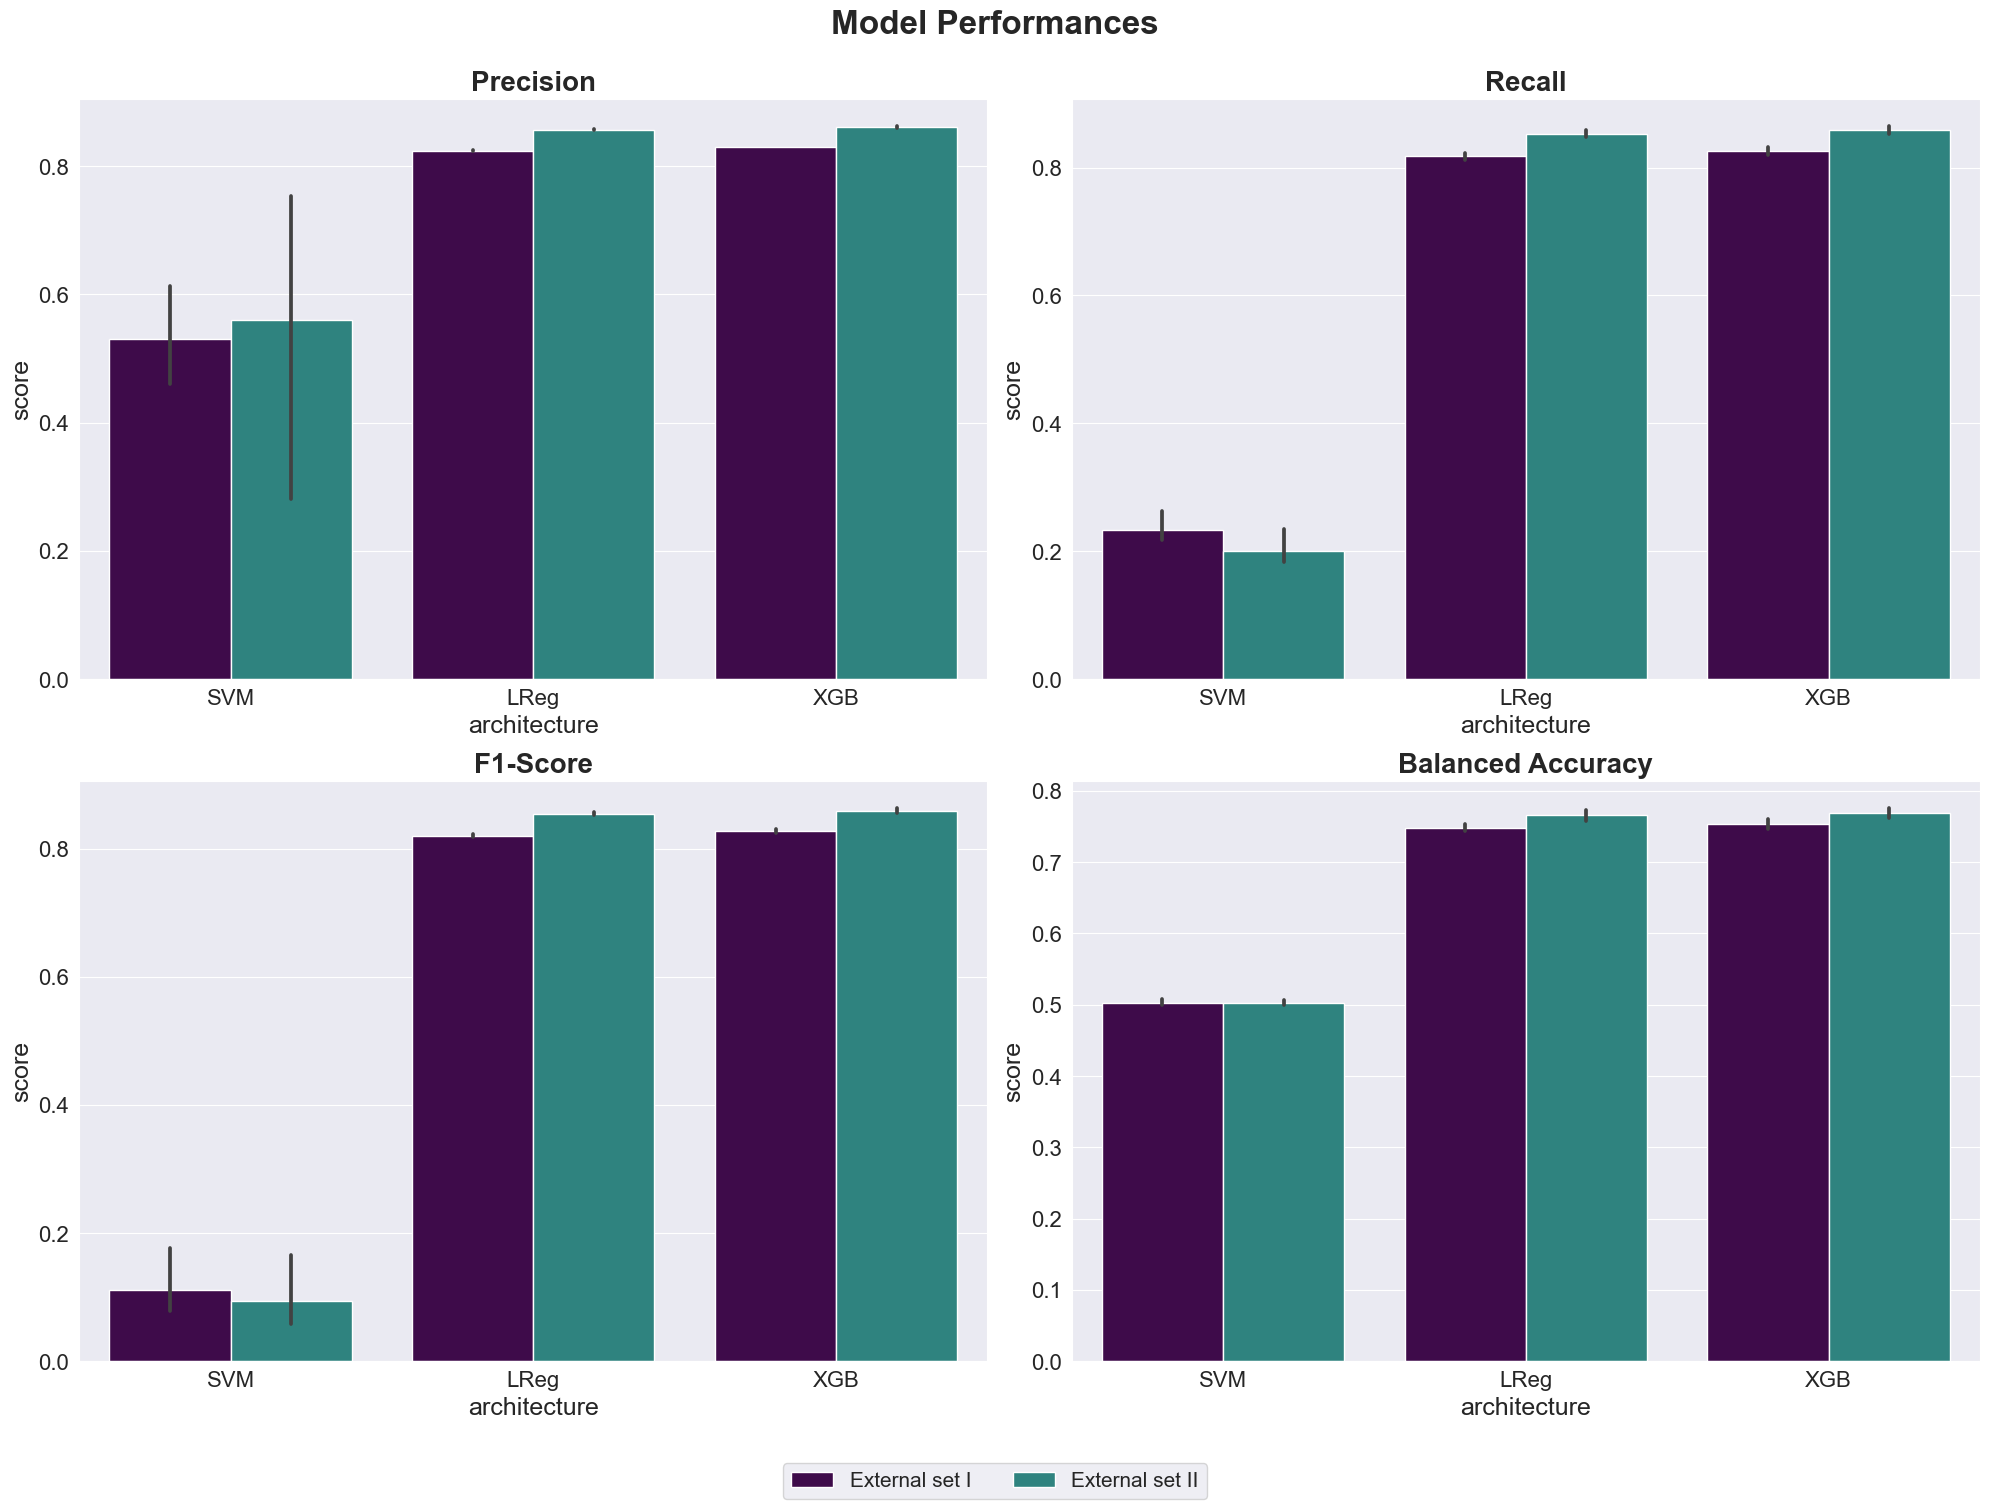

In [35]:
# Remove strings after "_"
df['Model'] = df['Model'].str.split('_').str[0]

# Use the seaborn darkgrid style
sns.set_style("darkgrid")

# List of metrics
metrics = ['Precision', 'Recall', 'F1-Score', 'Balanced Accuracy']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

handles, labels = None, None

# Custom palette
palette_colors = ['#440154', '#21918C', '#FDE725']


# Loop through each metric and create a subplot for each one
for ax, metric in zip(axes.ravel(), metrics):
    bars = sns.barplot(x='Model', y=metric, hue='Dataset', data=df, ax=ax, palette=palette_colors)
    
    # Bold the metric titles
    ax.set_title(metric, fontsize=20, fontweight='bold')
    
    ax.set_ylabel('score', fontsize=18)
    ax.set_xlabel('architecture', fontsize=18)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend().set_visible(False)  # hide the individual legend
    
    if handles is None:
        handles, labels = ax.get_legend_handles_labels()

# Add an overall title closer to the subplots
fig.suptitle('Model Performances', fontsize=24, fontweight='bold', y=0.95)

# Add a centralized legend closer to the plots
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=15, frameon=True, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/final_ext_model_performance_plot{DIS}{FET}.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
probs = best_model['model'].predict_proba(X_ext)[:,1]
preds = np.where(probs > best_model['threshold'], 1, 0)
print(classification_report(y_true=y_ext,
                        y_pred=preds))

with open(f"{PAT}/{MOD}/best_model_ext{DIS}{FET}", "wb") as fp:
    pickle.dump(best_model, fp)

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     24594
           1       0.63      0.58      0.60      6850

    accuracy                           0.83     31444
   macro avg       0.76      0.74      0.75     31444
weighted avg       0.83      0.83      0.83     31444



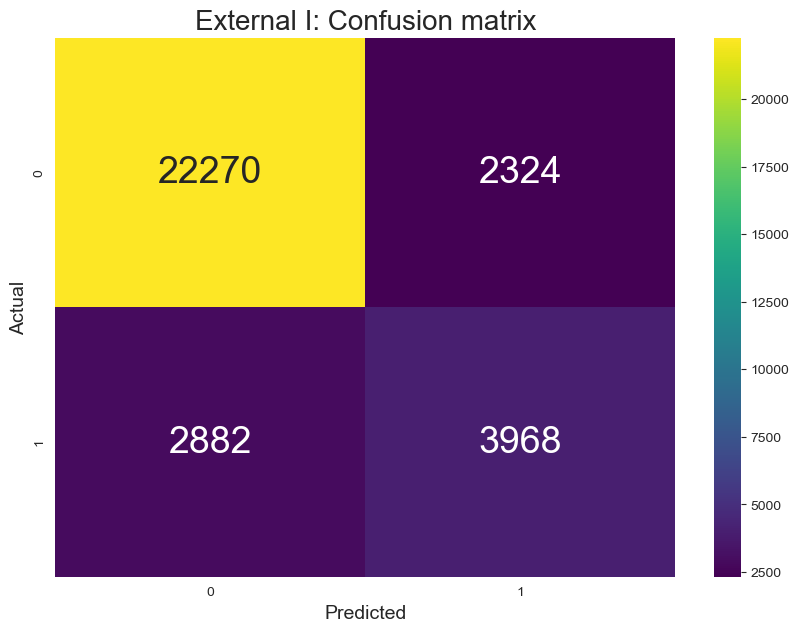

In [37]:
probs = best_model['model'].predict_proba(X_ext)[:,1]
preds = np.where(probs > best_model['threshold'], 1, 0)

cm = confusion_matrix(y_ext, preds) 


plt.figure(figsize=(10,7))
plt.title("External I: Confusion matrix", fontsize=20)
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", annot_kws={"size": 27})  # Adjust the font size here
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)

# Save the figure in high resolution
plt.savefig(f"{PAT}/{MOD}/final_confusion_matrix_ext{DIS}{FET}.png", dpi=300)

plt.show()

In [38]:
probs = best_model['model'].predict_proba(X_trace)[:,1]
preds = np.where(probs > best_model['threshold'], 1, 0)

print(classification_report(y_true=y_trace,
                        y_pred=preds))

with open(f"{PAT}/{MOD}/best_model_trace{DIS}{FET}", "wb") as fp:
    pickle.dump(best_model, fp)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3239
           1       0.65      0.58      0.62       728

    accuracy                           0.87      3967
   macro avg       0.78      0.76      0.77      3967
weighted avg       0.86      0.87      0.86      3967



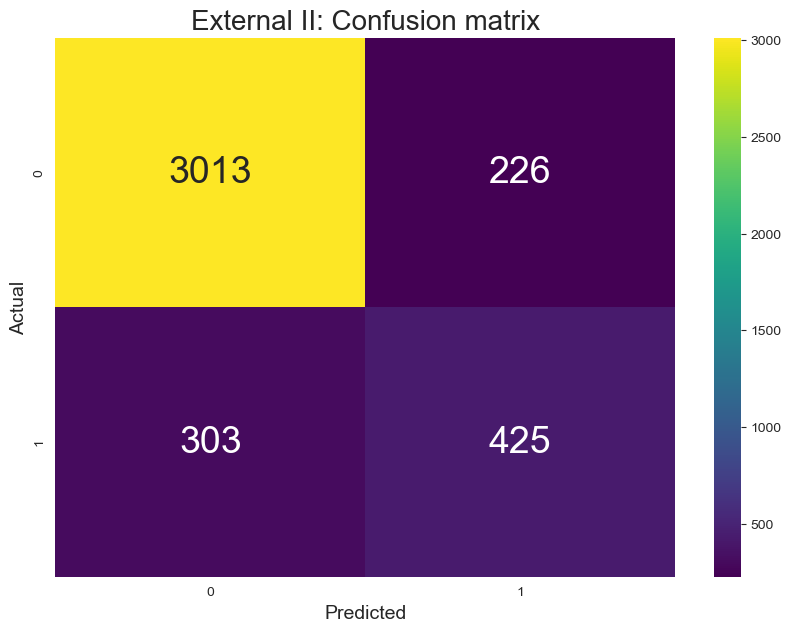

In [39]:
probs = best_model['model'].predict_proba(X_trace)[:,1]
preds = np.where(probs > best_model['threshold'], 1, 0)

cm = confusion_matrix(y_trace, preds) 
plt.figure(figsize=(10,7))
plt.title("External II: Confusion matrix", fontsize=20)
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", annot_kws={"size": 27})  # Adjust the font size here
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)

# Save the figure in high resolution
plt.savefig(f"{PAT}/{MOD}/final_confusion_matrix_trace{DIS}{FET}.png", dpi=300)

plt.show()

In [40]:
best_feats

Index(['APOA', 'APOB', 'Age', 'BMI', 'Bread_intake', 'CRP', 'Cereal_intake',
       'Cholesterol', 'Coffee_intake', 'Cooked_vegetable_intake',
       'Fasting_time', 'Fed-up_feelings', 'Frequency_friend_family_visits',
       'Fresh_fruit_intake', 'Glucose', 'HDL', 'HbA1c', 'Hip_circumference',
       'IGF_1', 'Loneliness_isolation', 'Mean_time_to_identify_matches',
       'Miserableness', 'Mood_swings', 'Number_operation',
       'Other_serious_condition', 'Overall_health_rating',
       'Salad/raw_vegetable_intake', 'Sensitivity', 'Sleep_duration',
       'Sleeplessness', 'Standing_height', 'Suffer_from_nerves', 'Tea_intake',
       'Tenseness_2weeks', 'Testosterone', 'Time_outdoors_summer',
       'Time_outdoors_winter', 'Tiredness_2weeks', 'Triglyceride',
       'Unenthusiasm_2weeks', 'Waist_circumference', 'Water_intake', 'Weight',
       'Worrier/Anxious_feelings', 'PastCVD'],
      dtype='object')

In [41]:
# Plot the SHAP values for a single prediction (for example, the first instance)
shap.initjs()

In [267]:
import matplotlib.colors as mcolors

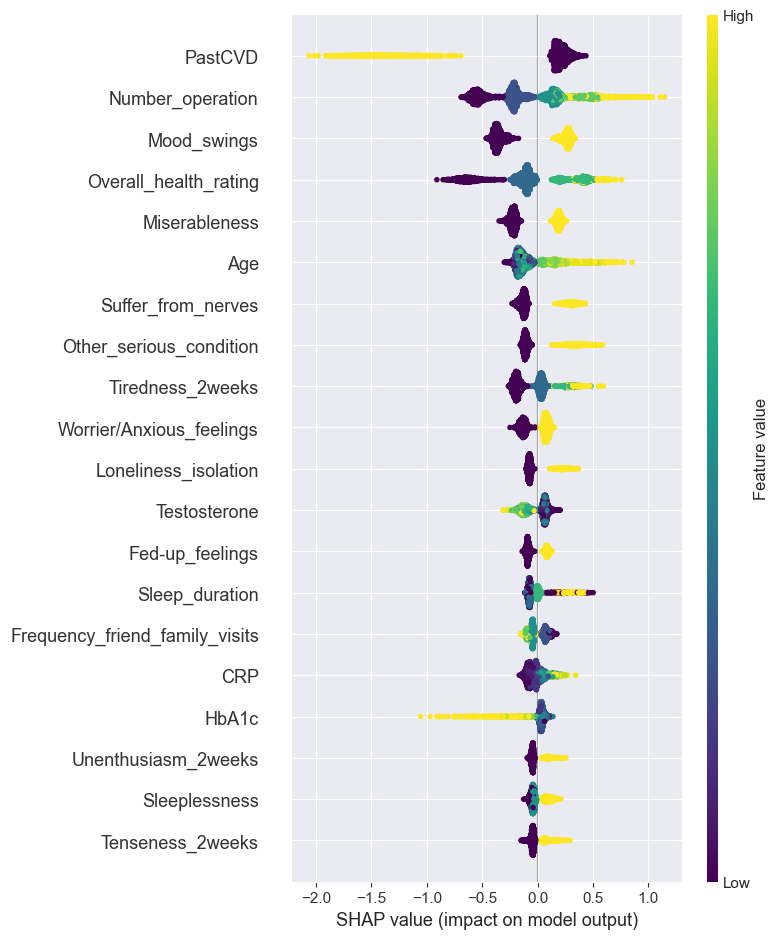

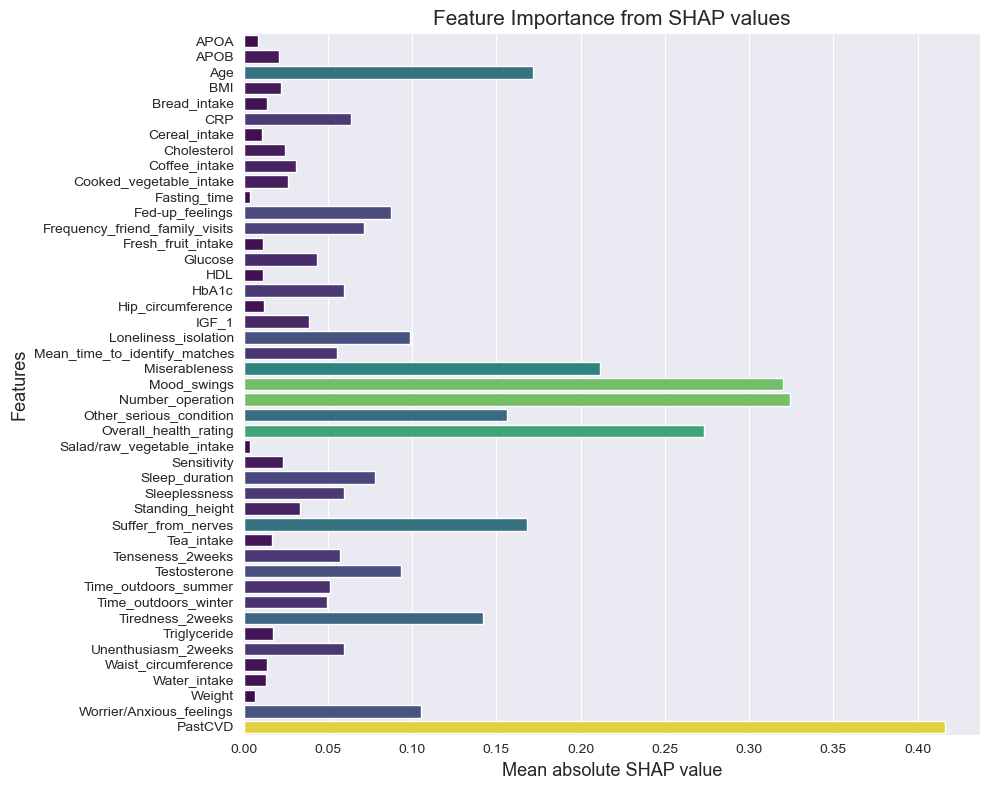

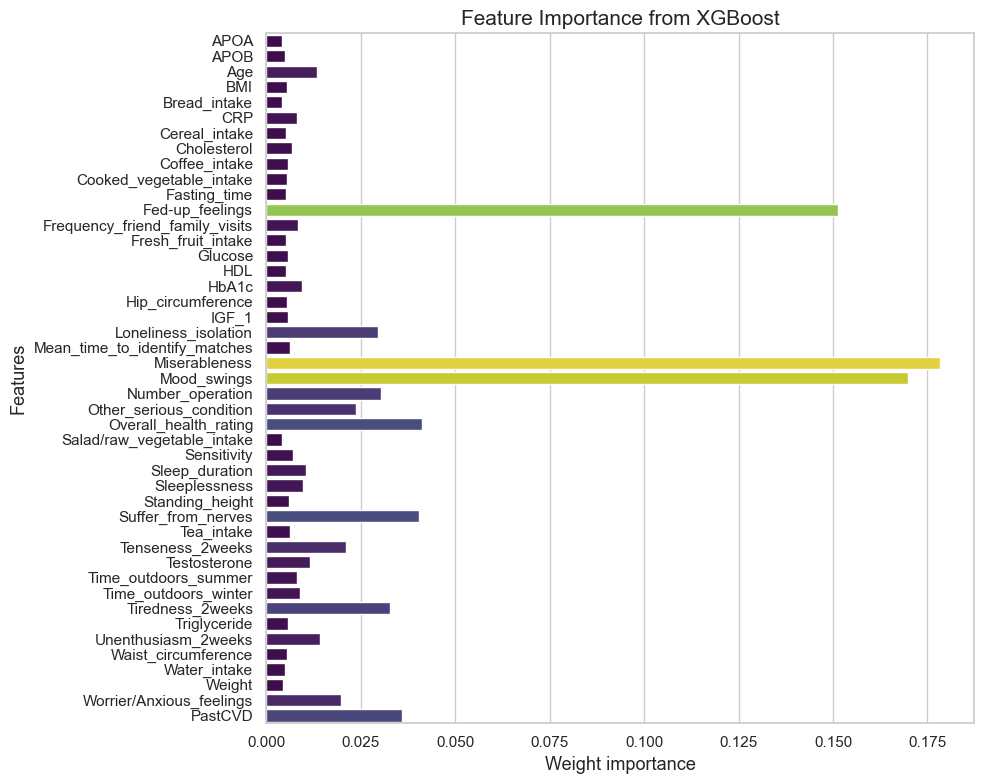

In [268]:
# First, manually apply transformations in the pipeline to the data
X_temp = X_trace.copy()

# Apply imputation
imputer = best_model['model'].named_steps['impute']
X_temp = imputer.transform(X_temp)

# Apply feature selection
selector = best_model['model'].named_steps['select_features']
X_temp = selector.transform(X_temp)

# Now, X_temp contains the transformed data. Use this with the XGB model for SHAP values
xgb_model = best_model['model'].named_steps['XGB']

# Initialize SHAP for the XGB model
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_temp)


#############################################################################
#############################################################################
fig, ax = plt.subplots(figsize=(10, 8))

# Create a colormap that maps from SHAP values to viridis colors
# Assuming shap_values are for a classification task and have two dimensions: [n_samples, n_features]
# For regression tasks, you might need to adapt this.
max_val = np.abs(shap_values).max()
colors = plt.get_cmap('viridis')
shap_colors = [colors(i) for i in np.linspace(0, 1, 256)]
cmap = mcolors.LinearSegmentedColormap.from_list("shap_viridis", shap_colors)

# Use the created axis in the shap.summary_plot with modified color
shap.summary_plot(shap_values, X_temp, feature_names=list(best_feats), cmap=cmap)

# Now save this figure
fig.tight_layout()
fig.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/shap_summary_plot_trace{FET}.png', dpi=300)

# And finally show the plot
plt.show()

#############################################################################
#############################################################################
# Compute mean absolute SHAP values for each feature
shap_summary = np.abs(shap_values).mean(axis=0)

# Normalize shap_summary to [0,1]
norm_shap_summary = (shap_summary - min(shap_summary)) / (max(shap_summary) - min(shap_summary))

# Generate color array based on normalized shap values
colors_shap = plt.get_cmap('viridis')(norm_shap_summary)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(y=best_feats, x=shap_summary, palette=colors_shap)
plt.xlabel('Mean absolute SHAP value', fontsize=13)
plt.ylabel('Features', fontsize=13)
plt.title('Feature Importance from SHAP values', fontsize=15)
plt.tight_layout()
plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/shap_feature_importance_trace{FET}.png', dpi=300)
plt.show()

#############################################################################
#############################################################################
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Get feature importances and normalize to [0,1]
importances = xgb_model.feature_importances_
norm_importances = (importances - min(importances)) / (max(importances) - min(importances))

# Generate color array based on normalized importance values
colors = plt.get_cmap('viridis')(norm_importances)

# Plot using seaborn's barplot
sns.barplot(y=best_feats, x=importances, palette=colors)
plt.title("Feature Importance from XGBoost", fontsize=15)
plt.xlabel('Weight importance', fontsize=13)
plt.ylabel('Features', fontsize=13)
plt.tight_layout()
plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/xgboost_weight_feature_importance_trace{FET}.png', dpi=300)
plt.show()

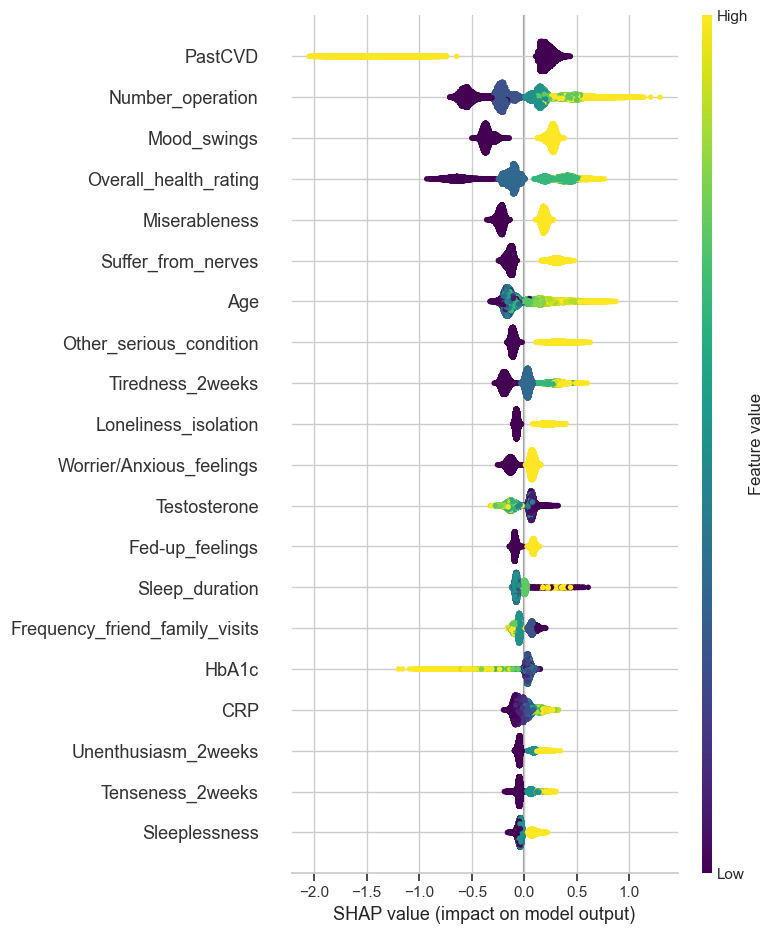

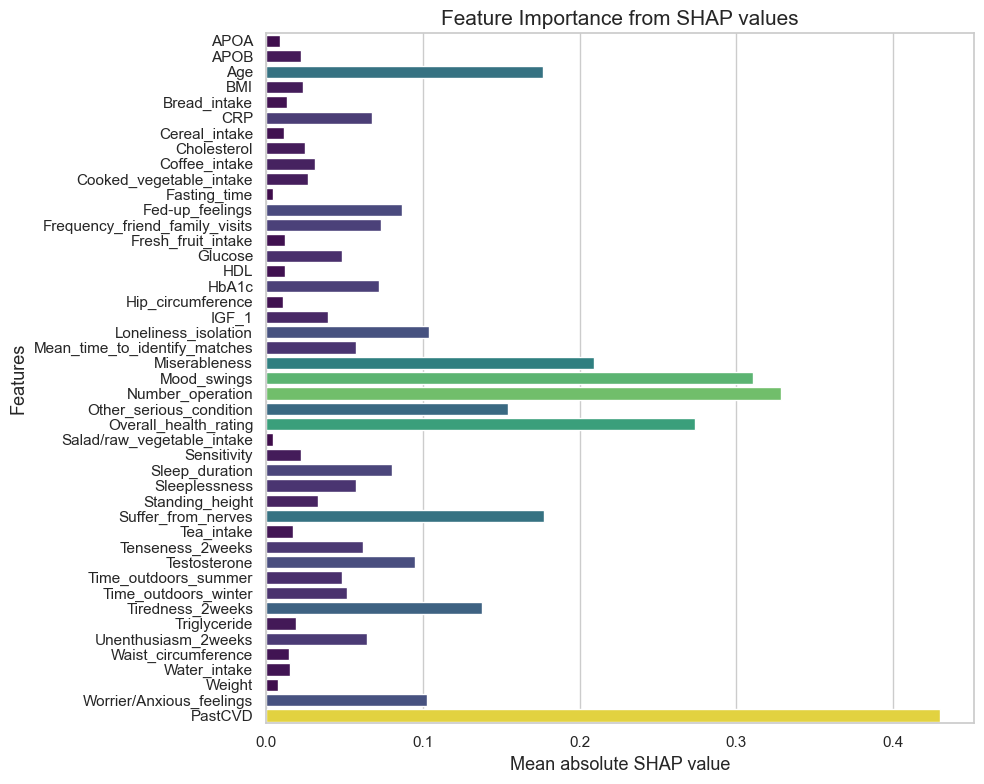

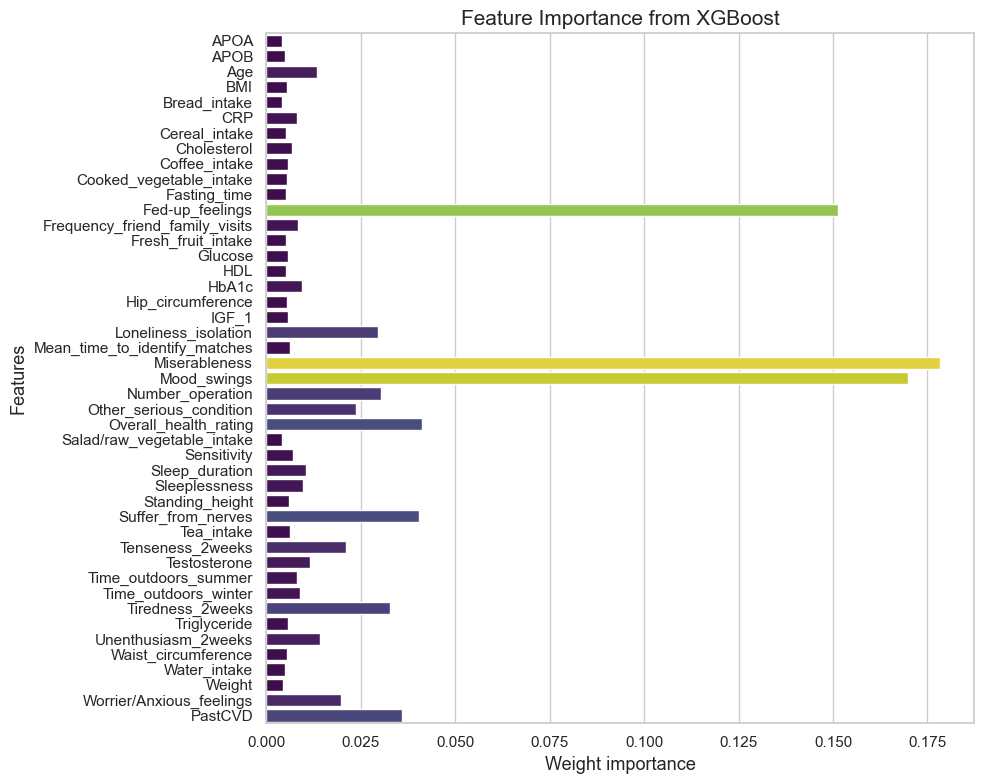

In [269]:
# First, manually apply transformations in the pipeline to the data
X_temp = X_ext.copy()

# Apply imputation
imputer = best_model['model'].named_steps['impute']
X_temp = imputer.transform(X_temp)

# Apply feature selection
selector = best_model['model'].named_steps['select_features']
X_temp = selector.transform(X_temp)

# Now, X_temp contains the transformed data. Use this with the XGB model for SHAP values
xgb_model = best_model['model'].named_steps['XGB']

# Initialize SHAP for the XGB model
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_temp)


#############################################################################
#############################################################################
fig, ax = plt.subplots(figsize=(10, 8))

# Create a colormap that maps from SHAP values to viridis colors
# Assuming shap_values are for a classification task and have two dimensions: [n_samples, n_features]
# For regression tasks, you might need to adapt this.
max_val = np.abs(shap_values).max()
colors = plt.get_cmap('viridis')
shap_colors = [colors(i) for i in np.linspace(0, 1, 256)]
cmap = mcolors.LinearSegmentedColormap.from_list("shap_viridis", shap_colors)

# Use the created axis in the shap.summary_plot with modified color
shap.summary_plot(shap_values, X_temp, feature_names=list(best_feats), cmap=cmap)

# Now save this figure
fig.tight_layout()
fig.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/shap_summary_plot_ext{FET}.png', dpi=300)

# And finally show the plot
plt.show()

#############################################################################
#############################################################################
# Compute mean absolute SHAP values for each feature
shap_summary = np.abs(shap_values).mean(axis=0)

# Normalize shap_summary to [0,1]
norm_shap_summary = (shap_summary - min(shap_summary)) / (max(shap_summary) - min(shap_summary))

# Generate color array based on normalized shap values
colors_shap = plt.get_cmap('viridis')(norm_shap_summary)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(y=best_feats, x=shap_summary, palette=colors_shap)
plt.xlabel('Mean absolute SHAP value', fontsize=13)
plt.ylabel('Features', fontsize=13)
plt.title('Feature Importance from SHAP values', fontsize=15)
plt.tight_layout()
plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/shap_feature_importance_ext{FET}.png', dpi=300)
plt.show()

#############################################################################
#############################################################################
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Get feature importances and normalize to [0,1]
importances = xgb_model.feature_importances_
norm_importances = (importances - min(importances)) / (max(importances) - min(importances))

# Generate color array based on normalized importance values
colors = plt.get_cmap('viridis')(norm_importances)

# Plot using seaborn's barplot
sns.barplot(y=best_feats, x=importances, palette=colors)
plt.title("Feature Importance from XGBoost", fontsize=15)
plt.xlabel('Weight importance', fontsize=13)
plt.ylabel('Features', fontsize=13)
plt.tight_layout()
plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/xgboost_feature_importance_ext{FET}.png', dpi=300)
plt.show()

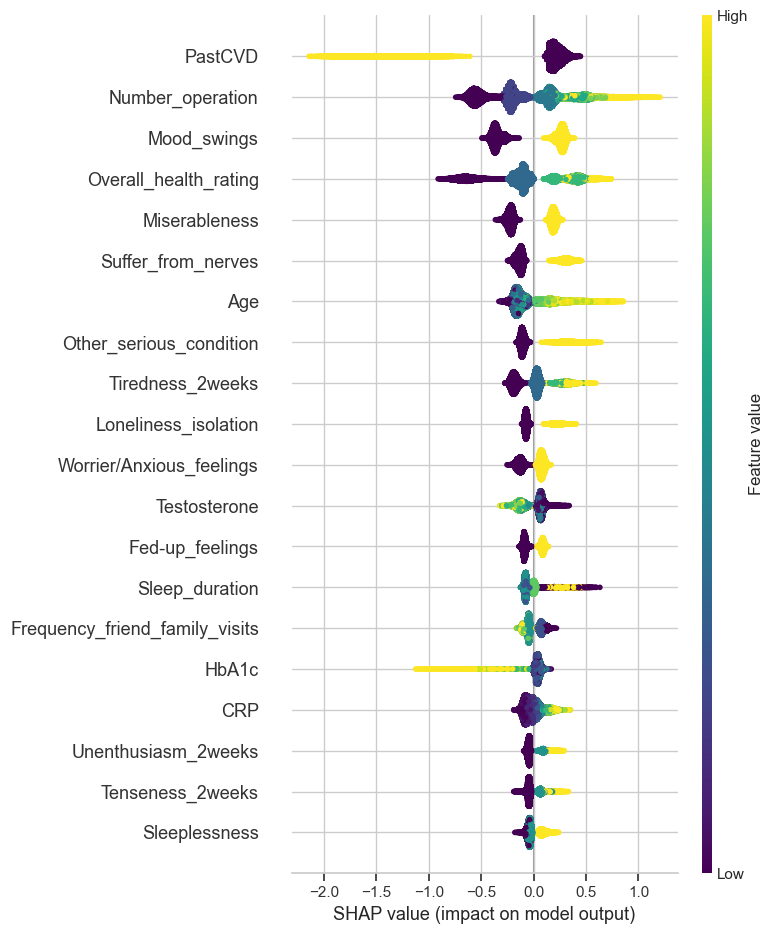

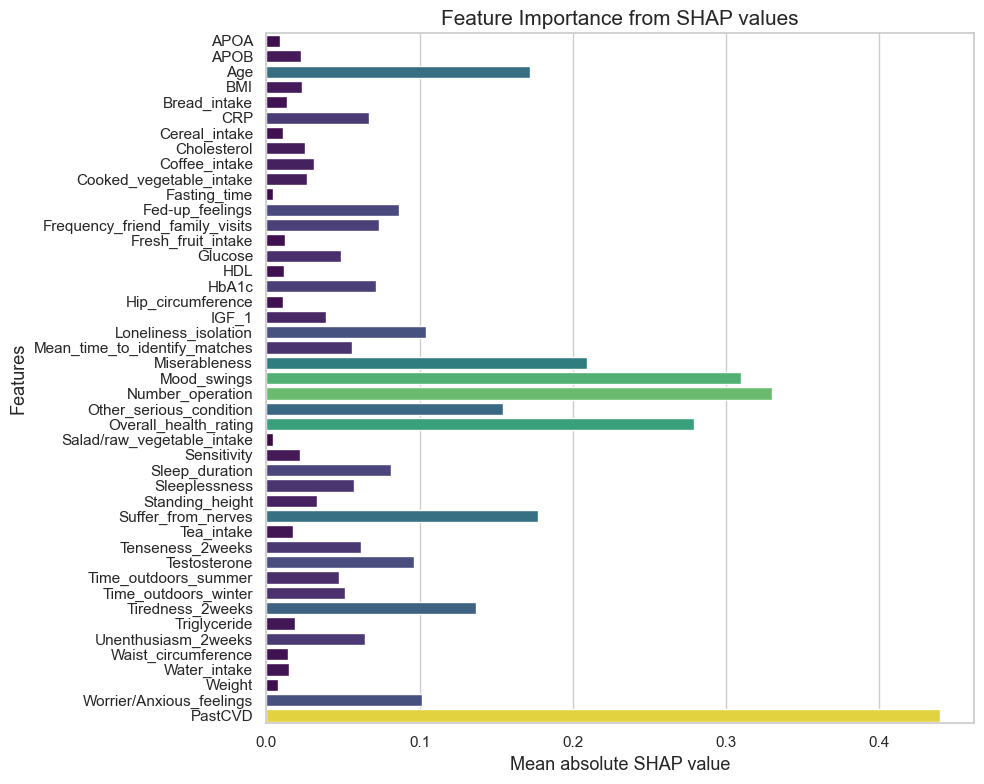

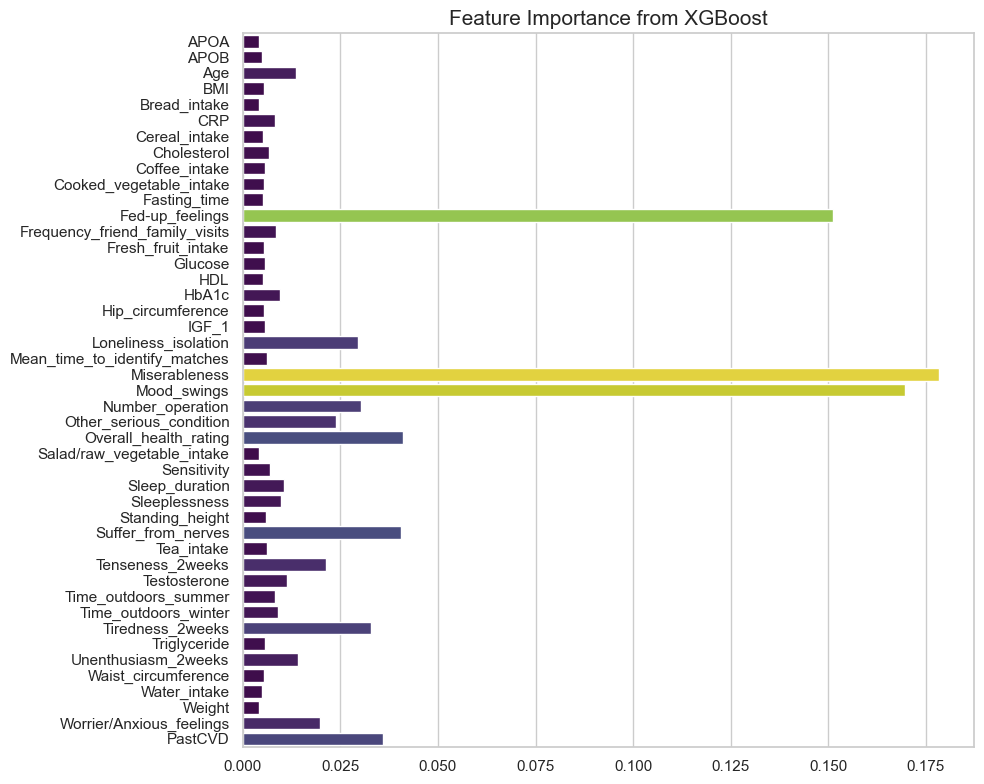

In [270]:
# First, manually apply transformations in the pipeline to the data
X_temp = trainData.copy()

# Apply imputation
imputer = best_model['model'].named_steps['impute']
X_temp = imputer.transform(X_temp)

# Apply feature selection
selector = best_model['model'].named_steps['select_features']
X_temp = selector.transform(X_temp)

# Now, X_temp contains the transformed data. Use this with the XGB model for SHAP values
xgb_model = best_model['model'].named_steps['XGB']

# Initialize SHAP for the XGB model
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_temp)


#############################################################################
#############################################################################
fig, ax = plt.subplots(figsize=(10, 8))

# Create a colormap that maps from SHAP values to viridis colors
# Assuming shap_values are for a classification task and have two dimensions: [n_samples, n_features]
# For regression tasks, you might need to adapt this.
max_val = np.abs(shap_values).max()
colors = plt.get_cmap('viridis')
shap_colors = [colors(i) for i in np.linspace(0, 1, 256)]
cmap = mcolors.LinearSegmentedColormap.from_list("shap_viridis", shap_colors)

# Use the created axis in the shap.summary_plot with modified color
shap.summary_plot(shap_values, X_temp, feature_names=list(best_feats), cmap=cmap)

# Now save this figure
fig.tight_layout()
fig.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/shap_summary_plot_train{FET}.png', dpi=300)

# And finally show the plot
plt.show()

#############################################################################
#############################################################################
# Compute mean absolute SHAP values for each feature
shap_summary = np.abs(shap_values).mean(axis=0)

# Normalize shap_summary to [0,1]
norm_shap_summary = (shap_summary - min(shap_summary)) / (max(shap_summary) - min(shap_summary))

# Generate color array based on normalized shap values
colors_shap = plt.get_cmap('viridis')(norm_shap_summary)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(y=best_feats, x=shap_summary, palette=colors_shap)
plt.xlabel('Mean absolute SHAP value', fontsize=13)
plt.ylabel('Features', fontsize=13)
plt.title('Feature Importance from SHAP values', fontsize=15)
plt.tight_layout()
plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/shap_feature_importance_train{FET}.png', dpi=300)
plt.show()

#############################################################################
#############################################################################
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Get feature importances and normalize to [0,1]
importances = xgb_model.feature_importances_
norm_importances = (importances - min(importances)) / (max(importances) - min(importances))

# Generate color array based on normalized importance values
colors = plt.get_cmap('viridis')(norm_importances)

# Plot using seaborn's barplot
sns.barplot(y=best_feats, x=importances, palette=colors)
plt.title("Feature Importance from XGBoost", fontsize=15)
plt.tight_layout()
plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/xgboost_feature_importance_train{FET}.png', dpi=300)
plt.show()

In [42]:
fair0 = pd.read_csv("/Users/marinacamacho/Desktop/Master_I/Modelling/Sex0.csv",delimiter="\,")
fair0 = fair0.set_index('eid')
fair2 = pd.read_csv("/Users/marinacamacho/Desktop/Master_I/Modelling/Sex1.csv",delimiter="\,")
fair2 = fair2.set_index('eid')

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [43]:
fair_trace = fair2[fair2.index.isin(traceCohort.index)]
fair_ext = fair0[fair0.index.isin(extCohort.index)]
fair_train = fair0[fair0.index.isin(trainData.index)]

In [44]:
(fair_trace.shape[0]==traceCohort.shape[0]) and (fair_ext.shape[0]==extCohort.shape[0]) and (fair_train.shape[0]==trainData.shape[0])

True

In [45]:
fair_trace_list = fair_trace['Sex']
fair_ext_list = fair_ext['Sex']
fair_train_list = fair_train['Sex']

In [46]:
LOAD = "/Users/marinacamacho/Desktop/Master_I/Raw_Data"
Cols = ["f.eid","Ethnic", "Skin_colour", "Sex"]
# Exposome data
fair = pd.read_csv(f'{LOAD}/Time_0/all_exposome_0.csv', usecols=lambda col: col in Cols)
fair = fair.set_index('f.eid')
fair = fair.sort_index(axis=1)
fair.index.name = 'eid'

fair2 = pd.read_csv(f'{LOAD}/Time_1/all_exposome_1.csv', usecols=lambda col: col in Cols)
fair2 = fair2.set_index('f.eid')
fair2 = fair2.sort_index(axis=1)
fair2.index.name = 'eid'

fair['Skin_colour'] = fair['Skin_colour'].replace([1,2,3,4,5,6,-1,-3],[0,0,0,0,1,1,np.nan,np.nan])   
fair2['Skin_colour'] = fair2['Skin_colour'].replace([1,2,3,4,5,6,-1,-3],[0,0,0,0,1,1,np.nan,np.nan])    

fair['Ethnic'] = fair['Ethnic'].replace([1,1001,1002,1003],[0,0,0,0])   
fair['Ethnic'] = fair['Ethnic'].replace([2,2001,2002,2003,2004,3,3001,3002,3003,3004,4,4001,4002,4003,5],[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])   
fair['Ethnic'] = fair['Ethnic'].replace([6,-1,-3],[np.nan,np.nan,np.nan])   

fair2['Ethnic'] = fair2['Ethnic'].replace([1,1001,1002,1003],[0,0,0,0])   
fair2['Ethnic'] = fair2['Ethnic'].replace([2,2001,2002,2003,2004,3,3001,3002,3003,3004,4,4001,4002,4003,5],[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])   
fair2['Ethnic'] = fair2['Ethnic'].replace([6,-1,-3],[np.nan,np.nan,np.nan])

fair_trace = fair2[fair2.index.isin(traceCohort.index)]
fair_ext = fair[fair.index.isin(extCohort.index)]
fair_train = fair[fair.index.isin(trainData.index)]

In [48]:
def fairness_metrics_with_fairlearn(predictions, actuals, protected):
    # Convert to numpy arrays for consistency
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    protected = np.array(protected)

    # Verify that shapes match
    assert protected.shape == actuals.shape == predictions.shape, "Shapes of inputs do not match"

    # Demographic Parity Difference
    demo_parity_diff = demographic_parity_difference(y_true=actuals, y_pred=predictions, sensitive_features=protected)
    
    # Equalized Odds Difference: 
    # This combines both the true positive rate difference and the false positive rate difference.
    equal_opportunity_diff = equalized_odds_difference(y_true=actuals, y_pred=predictions, sensitive_features=protected)
    
    # False Positive Rate Difference
    fp_rate_diff = false_positive_rate_difference(y_true=actuals, y_pred=predictions, sensitive_features=protected)
    
    # False Negative Rate Difference
    fn_rate_diff = false_negative_rate_difference(y_true=actuals, y_pred=predictions, sensitive_features=protected)
    
    return demo_parity_diff, equal_opportunity_diff, fp_rate_diff, fn_rate_diff

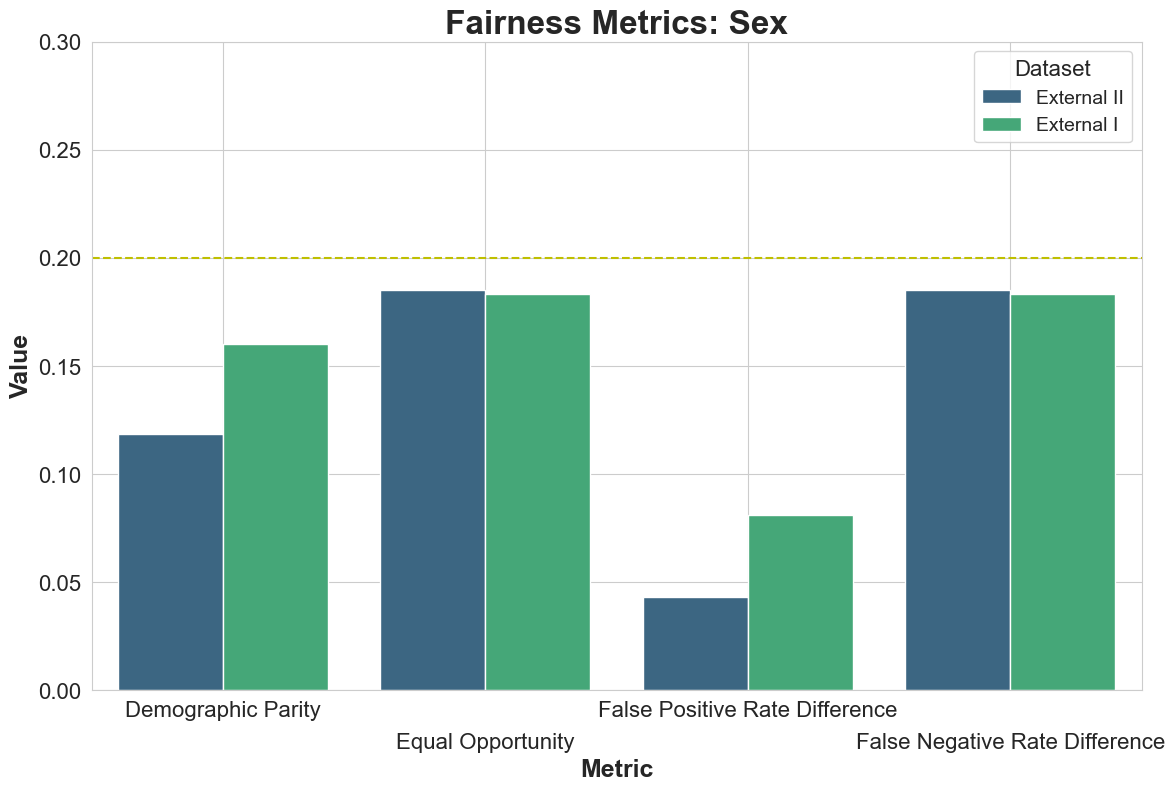

In [52]:
fair_trace_list = fair_trace['Sex']
fair_ext_list = fair_ext['Sex']

# Predict probabilities for the trace and external datasets
probs = best_model['model'].predict_proba(X_trace)[:,1]
probs_trace = np.where(probs > best_model['threshold'], 1, 0)

probs = best_model['model'].predict_proba(X_ext)[:,1]
probs_ext = np.where(probs > best_model['threshold'], 1, 0)

# Compute fairness metrics for both datasets using the function from fairlearn
metrics_trace = fairness_metrics_with_fairlearn(probs_trace, np.array(y_trace).flatten(), fair_trace_list)
metrics_ext = fairness_metrics_with_fairlearn(probs_ext, np.array(y_ext).flatten(), fair_ext_list)

metrics_names = [
    "Demographic Parity", 
    "Equal Opportunity", 
    "False Positive Rate Difference", 
    "False Negative Rate Difference"
]

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'Metric': metrics_names * 2,
    'Value': metrics_trace + metrics_ext,
    'Dataset': ['External II'] * len(metrics_names) + ['External I'] * len(metrics_names)
})


# Plotting
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.barplot(data=df, x='Metric', y='Value', hue='Dataset', palette='viridis')

# Set plot details
plt.ylim(0, 0.30)
plt.title('Fairness Metrics: Sex', fontsize=24, fontweight='bold')
plt.xlabel('Metric', fontsize=18, fontweight='bold')
plt.ylabel('Value', fontsize=18, fontweight='bold')
plt.grid(axis='y')
plt.grid(True)
plt.legend(title='Dataset', fontsize=14, title_fontsize=16)

# Adjust x-tick labels for staggering and increase their size
locs, labels = plt.xticks()  # get the current tick locations and labels
plt.setp(labels, rotation=0, fontsize=16)  # set the x-tick labels rotation to 45 degrees and align to the right
for i, label in enumerate(labels):
    position = label.get_position()
    if i % 2 == 0:  # if even index, adjust y-position to be lower
        label.set_position((position[0], position[1]))
    else:  # if odd index, adjust y-position to be higher
        label.set_position((position[0], position[1] - 0.05))

# Adjust the y-tick labels size
plt.yticks(fontsize=16)

# Save the plot
plt.tight_layout()

# Add horizontal lines at y=0.2 and y=-0.2
plt.axhline(y=0.2, color='y', linestyle='--')
#plt.axhline(y=-0.2, color='y', linestyle='--')

plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/fairness_sex_plot_combined{DIS}{FET}.png', dpi=300)

# Show the plot
plt.show()

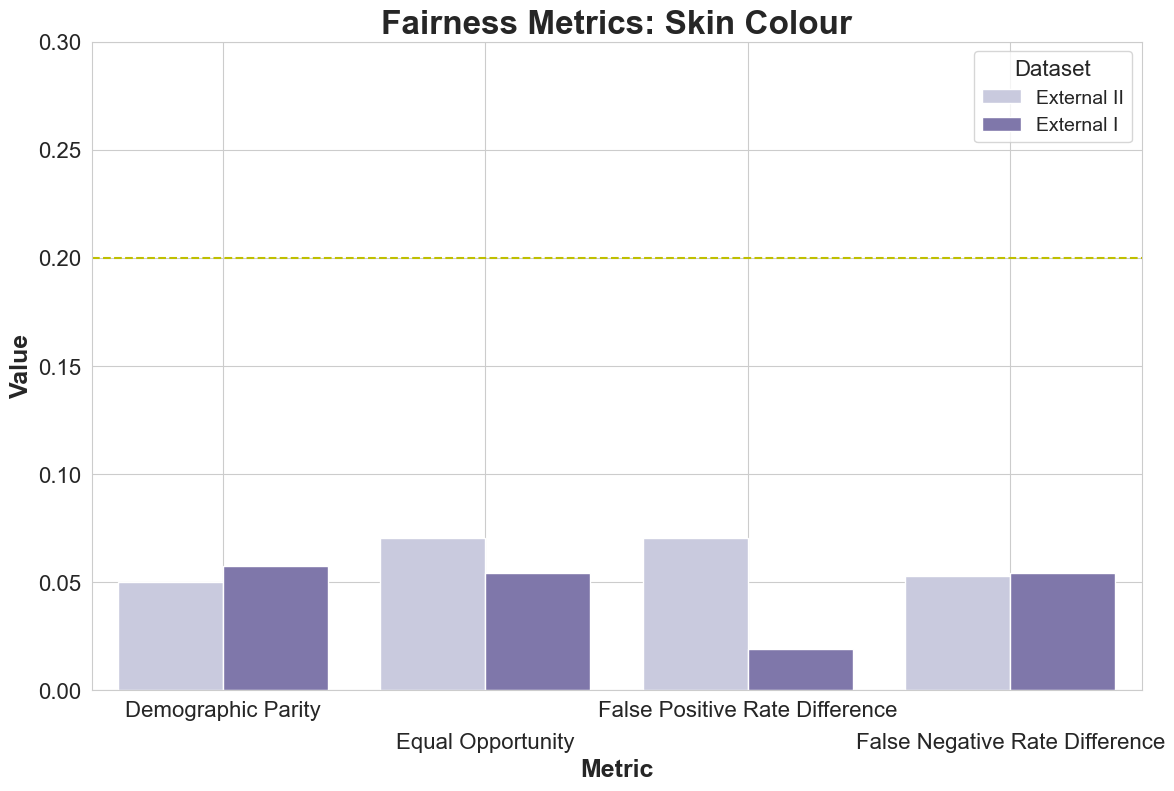

In [54]:
fair_trace_list = fair_trace['Skin_colour']
fair_ext_list = fair_ext['Skin_colour']

# Predict probabilities for the trace and external datasets
probs = best_model['model'].predict_proba(X_trace)[:,1]
probs_trace = np.where(probs > best_model['threshold'], 1, 0)

probs = best_model['model'].predict_proba(X_ext)[:,1]
probs_ext = np.where(probs > best_model['threshold'], 1, 0)

# Convert to numpy arrays
probs_trace = np.array(probs_trace)
y_trace = np.array(y_trace).flatten()
fair_trace_list = np.array(fair_trace_list)

probs_ext = np.array(probs_ext)
y_ext = np.array(y_ext).flatten()
fair_ext_list = np.array(fair_ext_list)

# Identify non-NaN indices for trace
non_nan_indices_trace = ~np.isnan(probs_trace) & ~np.isnan(y_trace) & ~np.isnan(fair_trace_list)

# Filter out NaN values for trace
probs_trace_clean = probs_trace[non_nan_indices_trace]
y_trace_clean = y_trace[non_nan_indices_trace]
fair_trace_list_clean = fair_trace_list[non_nan_indices_trace]

# Identify non-NaN indices for ext
non_nan_indices_ext = ~np.isnan(probs_ext) & ~np.isnan(y_ext) & ~np.isnan(fair_ext_list)

# Filter out NaN values for ext
probs_ext_clean = probs_ext[non_nan_indices_ext]
y_ext_clean = y_ext[non_nan_indices_ext]
fair_ext_list_clean = fair_ext_list[non_nan_indices_ext]

# Now, compute the fairness metrics using the cleaned data
metrics_trace = fairness_metrics_with_fairlearn(probs_trace_clean, y_trace_clean, fair_trace_list_clean)
metrics_ext = fairness_metrics_with_fairlearn(probs_ext_clean, y_ext_clean, fair_ext_list_clean)

metrics_names = [
    "Demographic Parity", 
    "Equal Opportunity", 
    "False Positive Rate Difference", 
    "False Negative Rate Difference"
]

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'Metric': metrics_names * 2,
    'Value': metrics_trace + metrics_ext,
    'Dataset': ['External II'] * len(metrics_names) + ['External I'] * len(metrics_names)
})


# Plotting
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.barplot(data=df, x='Metric', y='Value', hue='Dataset', palette='Purples')

# Set plot details
plt.ylim(0, 0.30)
plt.title('Fairness Metrics: Skin Colour', fontsize=24, fontweight='bold')
plt.xlabel('Metric', fontsize=18, fontweight='bold')
plt.ylabel('Value', fontsize=18, fontweight='bold')
plt.grid(axis='y')
plt.grid(True)
plt.legend(title='Dataset', fontsize=14, title_fontsize=16)

# Adjust x-tick labels for staggering and increase their size
locs, labels = plt.xticks()  # get the current tick locations and labels
plt.setp(labels, rotation=0, fontsize=16)  # set the x-tick labels rotation to 45 degrees and align to the right
for i, label in enumerate(labels):
    position = label.get_position()
    if i % 2 == 0:  # if even index, adjust y-position to be lower
        label.set_position((position[0], position[1]))
    else:  # if odd index, adjust y-position to be higher
        label.set_position((position[0], position[1] - 0.05))

# Adjust the y-tick labels size
plt.yticks(fontsize=16)

# Save the plot
plt.tight_layout()

# Add horizontal lines at y=0.2 and y=-0.2
plt.axhline(y=0.2, color='y', linestyle='--')
#plt.axhline(y=-0.2, color='y', linestyle='--')

plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/fairness_skin_plot_combined{DIS}{FET}.png', dpi=300)

# Show the plot
plt.show()

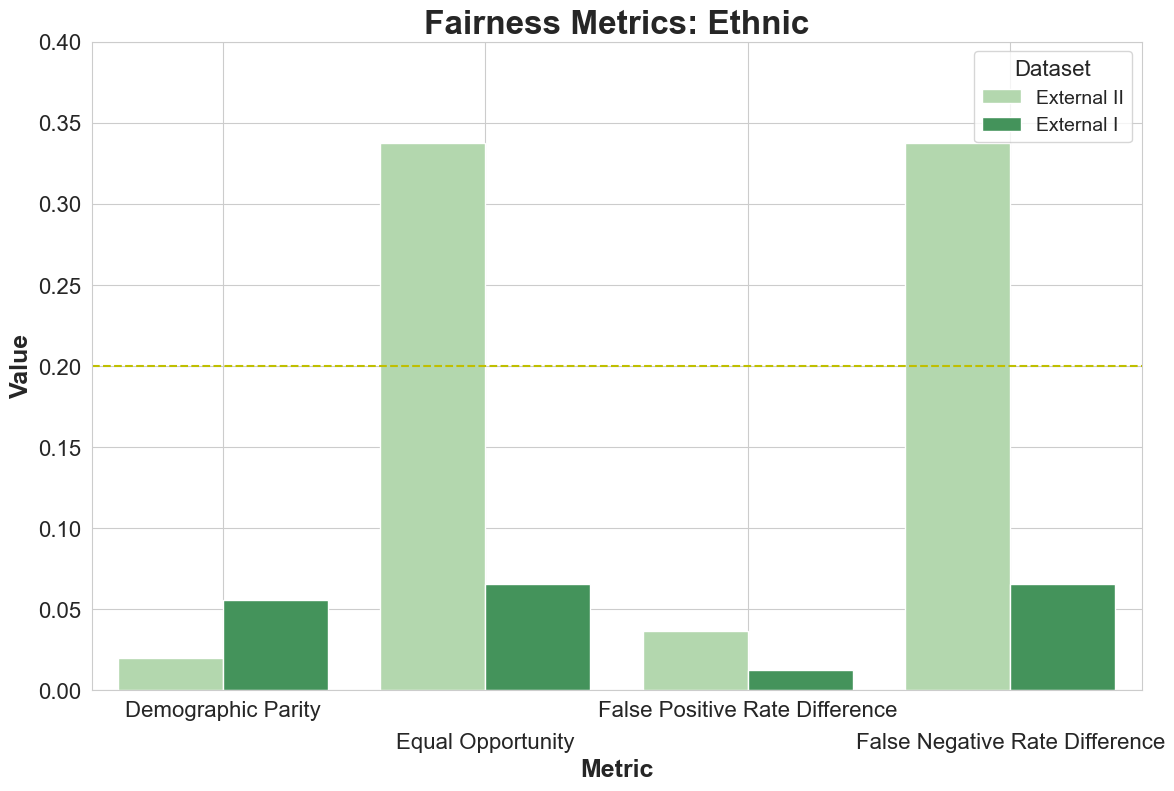

In [55]:
fair_trace_list = fair_trace['Ethnic']
fair_ext_list = fair_ext['Ethnic']

# Predict probabilities for the trace and external datasets
probs = best_model['model'].predict_proba(X_trace)[:,1]
probs_trace = np.where(probs > best_model['threshold'], 1, 0)

probs = best_model['model'].predict_proba(X_ext)[:,1]
probs_ext = np.where(probs > best_model['threshold'], 1, 0)

# Convert to numpy arrays
probs_trace = np.array(probs_trace)
y_trace = np.array(y_trace).flatten()
fair_trace_list = np.array(fair_trace_list)

probs_ext = np.array(probs_ext)
y_ext = np.array(y_ext).flatten()
fair_ext_list = np.array(fair_ext_list)

# Identify non-NaN indices for trace
non_nan_indices_trace = ~np.isnan(probs_trace) & ~np.isnan(y_trace) & ~np.isnan(fair_trace_list)

# Filter out NaN values for trace
probs_trace_clean = probs_trace[non_nan_indices_trace]
y_trace_clean = y_trace[non_nan_indices_trace]
fair_trace_list_clean = fair_trace_list[non_nan_indices_trace]

# Identify non-NaN indices for ext
non_nan_indices_ext = ~np.isnan(probs_ext) & ~np.isnan(y_ext) & ~np.isnan(fair_ext_list)

# Filter out NaN values for ext
probs_ext_clean = probs_ext[non_nan_indices_ext]
y_ext_clean = y_ext[non_nan_indices_ext]
fair_ext_list_clean = fair_ext_list[non_nan_indices_ext]

# Now, compute the fairness metrics using the cleaned data
metrics_trace = fairness_metrics_with_fairlearn(probs_trace_clean, y_trace_clean, fair_trace_list_clean)
metrics_ext = fairness_metrics_with_fairlearn(probs_ext_clean, y_ext_clean, fair_ext_list_clean)

metrics_names = [
    "Demographic Parity", 
    "Equal Opportunity", 
    "False Positive Rate Difference", 
    "False Negative Rate Difference"
]

# Note: I removed "True Negative Rate Difference" from metrics_names as it's not directly computed using fairlearn.

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'Metric': metrics_names * 2,
    'Value': metrics_trace + metrics_ext,
    'Dataset': ['External II'] * len(metrics_names) + ['External I'] * len(metrics_names)
})


# Plotting
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.barplot(data=df, x='Metric', y='Value', hue='Dataset', palette='Greens')

# Set plot details
plt.ylim(0, 0.40)
plt.title('Fairness Metrics: Ethnic', fontsize=24, fontweight='bold')
plt.xlabel('Metric', fontsize=18, fontweight='bold')
plt.ylabel('Value', fontsize=18, fontweight='bold')
plt.grid(axis='y')
plt.grid(True)
plt.legend(title='Dataset', fontsize=14, title_fontsize=16)

# Adjust x-tick labels for staggering and increase their size
locs, labels = plt.xticks()  # get the current tick locations and labels
plt.setp(labels, rotation=0, fontsize=16)  # set the x-tick labels rotation to 45 degrees and align to the right
for i, label in enumerate(labels):
    position = label.get_position()
    if i % 2 == 0:  # if even index, adjust y-position to be lower
        label.set_position((position[0], position[1]))
    else:  # if odd index, adjust y-position to be higher
        label.set_position((position[0], position[1] - 0.05))

# Adjust the y-tick labels size
plt.yticks(fontsize=16)

# Save the plot
plt.tight_layout()

# Add horizontal lines at y=0.2 and y=-0.2
plt.axhline(y=0.2, color='y', linestyle='--')
#plt.axhline(y=-0.2, color='y', linestyle='--')

plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/fairness_ethnic_plot_combined{DIS}{FET}.png', dpi=300)

# Show the plot
plt.show()

In [281]:
fair_trace['Ethnic'].value_counts()

0.0    3866
1.0    71  
Name: Ethnic, dtype: int64

In [282]:
71/(3866+71)*100

1.8034036068072135

In [283]:
fair_train['Ethnic'].value_counts()

0.0    68950
1.0    3383 
Name: Ethnic, dtype: int64

In [284]:
3383/(68950+3383)*100

4.676980078249208